<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Classification with Yelp, SGD, OOP

## Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.

---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
pd.set_option('display.max_columns', 50)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [3]:
business = pd.read_csv('./datasets/businesses_small_parsed.csv')
checkins = pd.read_csv('./datasets/checkins_small_parsed.csv')
reviews = pd.read_csv('./datasets/reviews_small_nlp_parsed.csv')
tips = pd.read_csv('./datasets/tips_small_nlp_parsed.csv')
users = pd.read_csv('./datasets/users_small_parsed.csv')

In [4]:
print business.shape
print business.columns

business.head(3)

(152832, 11)
Index([u'business_id', u'name', u'review_count', u'city', u'stars',
       u'categories', u'latitude', u'longitude', u'neighborhoods', u'variable',
       u'value'],
      dtype='object')


,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"['Bars', 'Nightlife', 'Dance Clubs']",33.455885,-112.074177,[],attributes.Ambience.divey,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"['Cafes', 'Mexican', 'Tex-Mex', 'Restaurants']",33.452154,-112.068620,[],attributes.Ambience.divey,False


In [5]:
business[business['business_id']=='EmzaQR5hQlF0WIl24NxAZA']

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.divey,False
2869,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Happy Hour,False
4190,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],hours.Thursday.open,09:00
6847,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],hours.Friday.open,09:00
9365,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Good For.latenight,False
11872,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Outdoor Seating,True
15139,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Alcohol,full_bar
18189,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.classy,False
21197,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Parking.lot,False
24624,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"['American (New)', 'Nightlife', 'Dance Clubs',...",33.448399,-112.071702,[],attributes.Ambience.touristy,False


In [6]:
business.shape

(152832, 11)

In [7]:
business.city.unique()

array(['Phoenix', 'Surprise', 'Las Vegas', 'Waterloo'], dtype=object)

In [8]:
categories = business.categories.apply(eval)
business_copy = business.copy()
business_copy['categories'] = categories
unique_categories = set(list(itertools.chain(*categories.tolist())))

In [9]:
#simplified list of categories
given_cats = ['Airports', 'Breakfast & Brunch', 'Bubble Tea', 'Burgers', 'Bars', 'Bakeries', 'Breweries',
             'Cafes', 'Candy Stores', 'Comedy Clubs', 'Courthouses', 'Dance Clubs', 'Fast Food', 
             'Museums', 'Tattoo', 'Vape Shops', 'Yoga']

    
for cat in given_cats:
    business_copy[cat] = business_copy['categories'].apply(lambda x: cat in x)


In [10]:
business_copy

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,"[Fast Food, Mexican, Tex-Mex, Restaurants]",33.465440,-112.069090,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,"[Bars, Restaurants, American (Traditional), Sp...",33.448465,-112.071257,[],attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
5,P7wKlbSRsoRrfH3DFOY08A,International House of Pancakes,57,Phoenix,3.0,"[Breakfast & Brunch, Restaurants]",33.475583,-112.074115,[],attributes.Ambience.divey,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,j8nyAaN_w5t6wYv-ni23sg,Coach & Willies,73,Phoenix,3.0,"[Nightlife, Bars, American (New), Sports Bars,...",33.443909,-112.070122,[],attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7,qsWxbgQwuomXvMseg23DGg,Hooters,113,Phoenix,2.5,"[Bars, American (Traditional), Sports Bars, Ni...",33.452335,-112.069614,[],attributes.Ambience.divey,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
8,9BH18avE46LlHMvJn67MaA,The Downtown Deli,57,Phoenix,4.0,"[Breakfast & Brunch, Delis, Sandwiches, Restau...",33.449952,-112.074051,[],attributes.Ambience.divey,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,tK91rSBc8SWa3XEQwe8D4A,Downtown,11,Phoenix,2.5,"[Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


In [11]:
# Convert the True/False in the restaurant_category_columns to 1/0
restaurant_category_columns = business_copy.columns.tolist()[-17:]

business_copy.loc[:, restaurant_category_columns] = business_copy[restaurant_category_columns].applymap(lambda x: 1 if x==True else 0)

business_copy.head(3)

,business_id,name,review_count,city,stars,categories,latitude,longitude,neighborhoods,variable,value,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,"[American (New), Nightlife, Dance Clubs, Resta...",33.448399,-112.071702,[],attributes.Ambience.divey,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,"[Bars, Nightlife, Dance Clubs]",33.455885,-112.074177,[],attributes.Ambience.divey,False,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,"[Cafes, Mexican, Tex-Mex, Restaurants]",33.452154,-112.068620,[],attributes.Ambience.divey,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [12]:
business_copy.drop(labels=['latitude','longitude','neighborhoods', 'categories'], axis=1, inplace=True)

In [13]:
business_copy.head()

,business_id,name,review_count,city,stars,variable,value,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,attributes.Ambience.divey,False,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,attributes.Ambience.divey,False,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,attributes.Ambience.divey,False,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,Phoenix,4.0,attributes.Ambience.divey,False,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,Phoenix,3.5,attributes.Ambience.divey,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
variables = business_copy[['business_id','variable','value']]

In [15]:
# variables.reset_index(inplace=True)

In [16]:
variables_pivot = variables.pivot(index='business_id', columns='variable', values='value')
# variables_pivot['attributes.Accepts Credit Cards'].unique()

In [17]:
variables_pivot.head(5)

variable,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,attributes.Ambience.divey,attributes.Ambience.hipster,attributes.Ambience.intimate,attributes.Ambience.romantic,attributes.Ambience.touristy,attributes.Ambience.trendy,attributes.Ambience.upscale,attributes.Attire,attributes.BYOB,attributes.BYOB/Corkage,attributes.By Appointment Only,attributes.Caters,attributes.Coat Check,attributes.Corkage,attributes.Delivery,attributes.Dietary Restrictions.dairy-free,attributes.Dietary Restrictions.gluten-free,attributes.Dietary Restrictions.halal,attributes.Dietary Restrictions.kosher,...,attributes.Parking.street,attributes.Parking.valet,attributes.Parking.validated,attributes.Price Range,attributes.Smoking,attributes.Take-out,attributes.Takes Reservations,attributes.Waiter Service,attributes.Wheelchair Accessible,attributes.Wi-Fi,hours.Friday.close,hours.Friday.open,hours.Monday.close,hours.Monday.open,hours.Saturday.close,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--jFTZmywe7StuZ2hEjxyA,True,None,None,none,None,None,None,None,None,None,None,None,None,casual,None,None,None,None,None,None,False,None,None,None,None,...,None,None,None,1.0,None,True,False,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,True
-0HGqwlfw3I8nkJyMHxAsQ,True,None,None,none,None,None,None,None,None,None,None,None,None,casual,None,None,None,False,None,None,False,None,None,None,None,...,False,False,False,1.0,None,True,False,False,None,free,None,None,None,None,None,None,None,None,None,None,None,None,None,None,True
-0VK5Z1BfUHUYq4PoBYNLw,True,None,None,full_bar,True,False,False,False,False,False,False,False,False,None,None,None,None,None,False,None,None,None,None,None,None,...,False,False,False,2.0,yes,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,True
-0bUDim5OGuv8R0Qqq6J4A,True,None,None,None,None,None,None,None,None,None,None,None,None,casual,None,None,None,None,None,None,False,None,None,None,None,...,False,False,False,1.0,None,True,False,True,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,False
-1bOb2izeJBZjHC7NWxiPA,True,None,None,none,True,False,False,False,False,False,False,False,False,casual,False,yes_free,None,True,None,False,False,None,None,None,None,...,False,False,False,1.0,None,True,False,True,True,free,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,True


In [18]:
variables_dummies = pd.get_dummies(data=variables_pivot)

In [19]:
variables_dummies.head(5)

,attributes.Accepts Credit Cards_False,attributes.Accepts Credit Cards_True,attributes.Accepts Insurance_False,attributes.Ages Allowed_18plus,attributes.Ages Allowed_21plus,attributes.Ages Allowed_allages,attributes.Alcohol_beer_and_wine,attributes.Alcohol_full_bar,attributes.Alcohol_none,attributes.Ambience.casual_False,attributes.Ambience.casual_True,attributes.Ambience.classy_False,attributes.Ambience.classy_True,attributes.Ambience.divey_False,attributes.Ambience.divey_True,attributes.Ambience.hipster_False,attributes.Ambience.hipster_True,attributes.Ambience.intimate_False,attributes.Ambience.intimate_True,attributes.Ambience.romantic_False,attributes.Ambience.romantic_True,attributes.Ambience.touristy_False,attributes.Ambience.touristy_True,attributes.Ambience.trendy_False,attributes.Ambience.trendy_True,...,hours.Wednesday.open_11:30,hours.Wednesday.open_12:00,hours.Wednesday.open_12:30,hours.Wednesday.open_13:00,hours.Wednesday.open_14:00,hours.Wednesday.open_14:30,hours.Wednesday.open_15:00,hours.Wednesday.open_15:30,hours.Wednesday.open_16:00,hours.Wednesday.open_16:30,hours.Wednesday.open_17:00,hours.Wednesday.open_17:30,hours.Wednesday.open_18:00,hours.Wednesday.open_18:30,hours.Wednesday.open_19:00,hours.Wednesday.open_19:30,hours.Wednesday.open_20:00,hours.Wednesday.open_20:30,hours.Wednesday.open_21:00,hours.Wednesday.open_21:30,hours.Wednesday.open_22:00,hours.Wednesday.open_22:30,hours.Wednesday.open_23:00,open_False,open_True
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--jFTZmywe7StuZ2hEjxyA,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-0HGqwlfw3I8nkJyMHxAsQ,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-0VK5Z1BfUHUYq4PoBYNLw,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
-0bUDim5OGuv8R0Qqq6J4A,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
-1bOb2izeJBZjHC7NWxiPA,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
variables_dummies.reset_index(inplace=True)
variables_dummies.head(3)

,business_id,attributes.Accepts Credit Cards_False,attributes.Accepts Credit Cards_True,attributes.Accepts Insurance_False,attributes.Ages Allowed_18plus,attributes.Ages Allowed_21plus,attributes.Ages Allowed_allages,attributes.Alcohol_beer_and_wine,attributes.Alcohol_full_bar,attributes.Alcohol_none,attributes.Ambience.casual_False,attributes.Ambience.casual_True,attributes.Ambience.classy_False,attributes.Ambience.classy_True,attributes.Ambience.divey_False,attributes.Ambience.divey_True,attributes.Ambience.hipster_False,attributes.Ambience.hipster_True,attributes.Ambience.intimate_False,attributes.Ambience.intimate_True,attributes.Ambience.romantic_False,attributes.Ambience.romantic_True,attributes.Ambience.touristy_False,attributes.Ambience.touristy_True,attributes.Ambience.trendy_False,...,hours.Wednesday.open_11:30,hours.Wednesday.open_12:00,hours.Wednesday.open_12:30,hours.Wednesday.open_13:00,hours.Wednesday.open_14:00,hours.Wednesday.open_14:30,hours.Wednesday.open_15:00,hours.Wednesday.open_15:30,hours.Wednesday.open_16:00,hours.Wednesday.open_16:30,hours.Wednesday.open_17:00,hours.Wednesday.open_17:30,hours.Wednesday.open_18:00,hours.Wednesday.open_18:30,hours.Wednesday.open_19:00,hours.Wednesday.open_19:30,hours.Wednesday.open_20:00,hours.Wednesday.open_20:30,hours.Wednesday.open_21:00,hours.Wednesday.open_21:30,hours.Wednesday.open_22:00,hours.Wednesday.open_22:30,hours.Wednesday.open_23:00,open_False,open_True
0,--jFTZmywe7StuZ2hEjxyA,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,-0HGqwlfw3I8nkJyMHxAsQ,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,-0VK5Z1BfUHUYq4PoBYNLw,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [21]:
business_dropped = business_copy.drop(labels=['variable','value'], axis=1)

business_dropped = business_dropped.drop_duplicates('business_id')

business_dropped.head(3)

,business_id,name,review_count,city,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,Phoenix,2.5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,Phoenix,3.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,Phoenix,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [24]:
business_cleaned = pd.merge(left=business_dropped, right=variables_dummies, how='inner', on='business_id')

In [25]:
cols = business_cleaned.columns.tolist()
# cols[:3] + cols[4:] + [cols[3]]
cols = cols[:3] + cols[4:] + [cols[3]]
business_cleaned = business_cleaned[cols]
business_cleaned.head()

,business_id,name,review_count,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga,attributes.Accepts Credit Cards_False,attributes.Accepts Credit Cards_True,attributes.Accepts Insurance_False,attributes.Ages Allowed_18plus,...,hours.Wednesday.open_12:00,hours.Wednesday.open_12:30,hours.Wednesday.open_13:00,hours.Wednesday.open_14:00,hours.Wednesday.open_14:30,hours.Wednesday.open_15:00,hours.Wednesday.open_15:30,hours.Wednesday.open_16:00,hours.Wednesday.open_16:30,hours.Wednesday.open_17:00,hours.Wednesday.open_17:30,hours.Wednesday.open_18:00,hours.Wednesday.open_18:30,hours.Wednesday.open_19:00,hours.Wednesday.open_19:30,hours.Wednesday.open_20:00,hours.Wednesday.open_20:30,hours.Wednesday.open_21:00,hours.Wednesday.open_21:30,hours.Wednesday.open_22:00,hours.Wednesday.open_22:30,hours.Wednesday.open_23:00,open_False,open_True,city
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,2.5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Phoenix
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,3.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Phoenix
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Phoenix
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,4.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Phoenix
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,3.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Phoenix


In [26]:
business_cleaned['city'] = business_cleaned['city'].apply(lambda x: 1 if x=='Las Vegas' else 0)

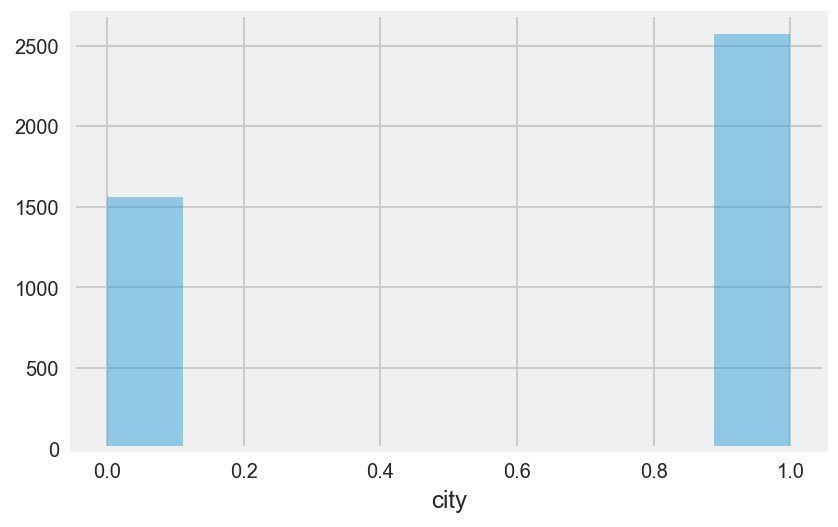

In [27]:
sns.distplot(business_cleaned['city'], kde=False)

In [28]:
from __future__ import division
baseline_accuracy = business_cleaned['city'].sum()/business_cleaned['city'].count()
print baseline_accuracy

0.621974830591


### EDA 
---

(0, 1000)

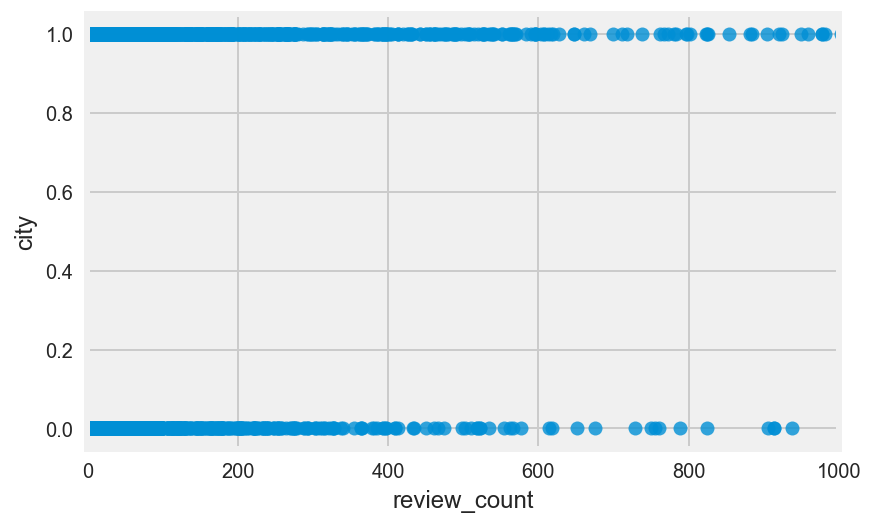

In [29]:
# Let's check to see if there is an association between review_count and city=='las vegas'
sns.regplot(x='review_count', y='city', data=business_cleaned, fit_reg=False)
plt.xlim((0, 1000))

Doesn't look like it. 

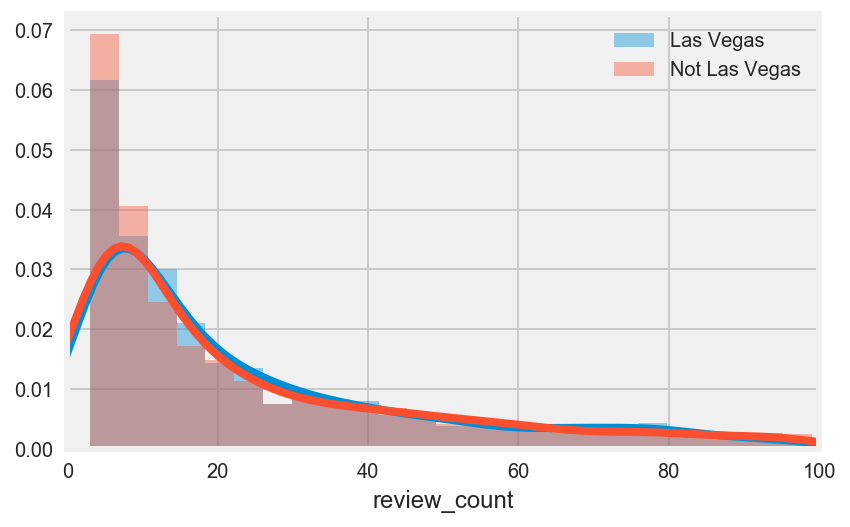

In [30]:
f = plt.figure()
mask1 = (business_cleaned['review_count']< 100) & (business_cleaned['city']==1)
mask2 = (business_cleaned['review_count']< 100) & (business_cleaned['city']==0)

ds = sns.distplot(a=business_cleaned[mask1].review_count, bins=25, label='Las Vegas')
ds = sns.distplot(a=business_cleaned[mask2].review_count, bins=25, label='Not Las Vegas')

axes = ds.axes
axes.set_xlim(0,100)
plt.legend()

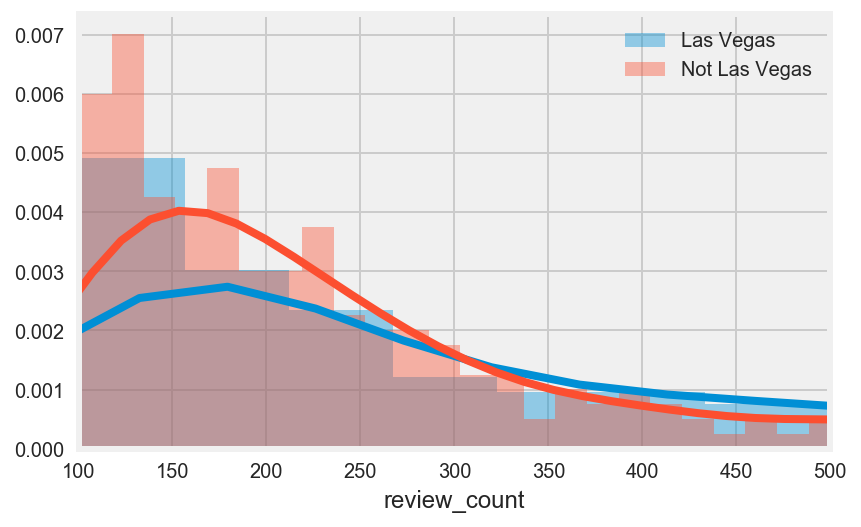

In [31]:
f = plt.figure()
mask1 = (business_cleaned['review_count'] > 100) & (business_cleaned['city']==1)
mask2 = (business_cleaned['review_count'] > 100) & (business_cleaned['city']==0)

ds = sns.distplot(a=business_cleaned[mask1].review_count, bins=100, label='Las Vegas')
ds = sns.distplot(a=business_cleaned[mask2].review_count, bins=100, label='Not Las Vegas')

axes = ds.axes

axes.set_xlim(100, 500)
plt.legend()

It seems like the review_count distribution is the same for Las Vegas businesses and non-Las Vegas businesses, so it probably doesn't make sense to include that as a factor. 
<br><br>

OK so I'm thinking that Las Vegas  might have a higher proportion of "late night" businesses than other cities. I'd like to plot the distribution of close times for las vegas businesses and compare them to the distribution of close times for the other cities, to see if there's a difference. if so, perhaps I can create a "late night" feature where a business classifies as late night if it closes late, like 2-4AM.

In [32]:
mask_vegas = business_cleaned['city']==1
mask_not_vegas = business_cleaned['city']==0

dfv = business_cleaned[mask_vegas]
dfnv = business_cleaned[mask_not_vegas]

In [33]:
all_times = []
for col in dfv.columns.tolist()[151:-3]:
    time = col.split('.')[2].split('_') 
    if time[0] == 'open':
        all_times.append(col)


In [34]:
# for col in late_night_cols:
#     if 1 in dfv[col].values:
#         print 'yes'

So all of the late night columns do contain at least one occurence of a value of 1. 

In [35]:
# For las vegas
open_close_cols = dfv.columns.tolist()[151:-3]

open_close_series = dfv[open_close_cols].apply(np.count_nonzero, axis=0)

open_close_series.name = 'count'

open_close_df = pd.DataFrame(open_close_series).reset_index()

open_close_df['index'] = open_close_df['index'].apply(lambda x: x.split('.')[2])

open_close_grouped_lv = open_close_df.groupby(by='index').sum()

# for non las vegas
open_close_cols = dfnv.columns.tolist()[151:-3]

open_close_series = dfnv[open_close_cols].apply(np.count_nonzero, axis=0)

open_close_series.name = 'count'

open_close_df = pd.DataFrame(open_close_series).reset_index()

open_close_df['index'] = open_close_df['index'].apply(lambda x: x.split('.')[2])

open_close_grouped_nlv = open_close_df.groupby(by='index').sum()

print open_close_grouped_lv.values[0]
print open_close_grouped_nlv.values[0]

[2683]
[760]


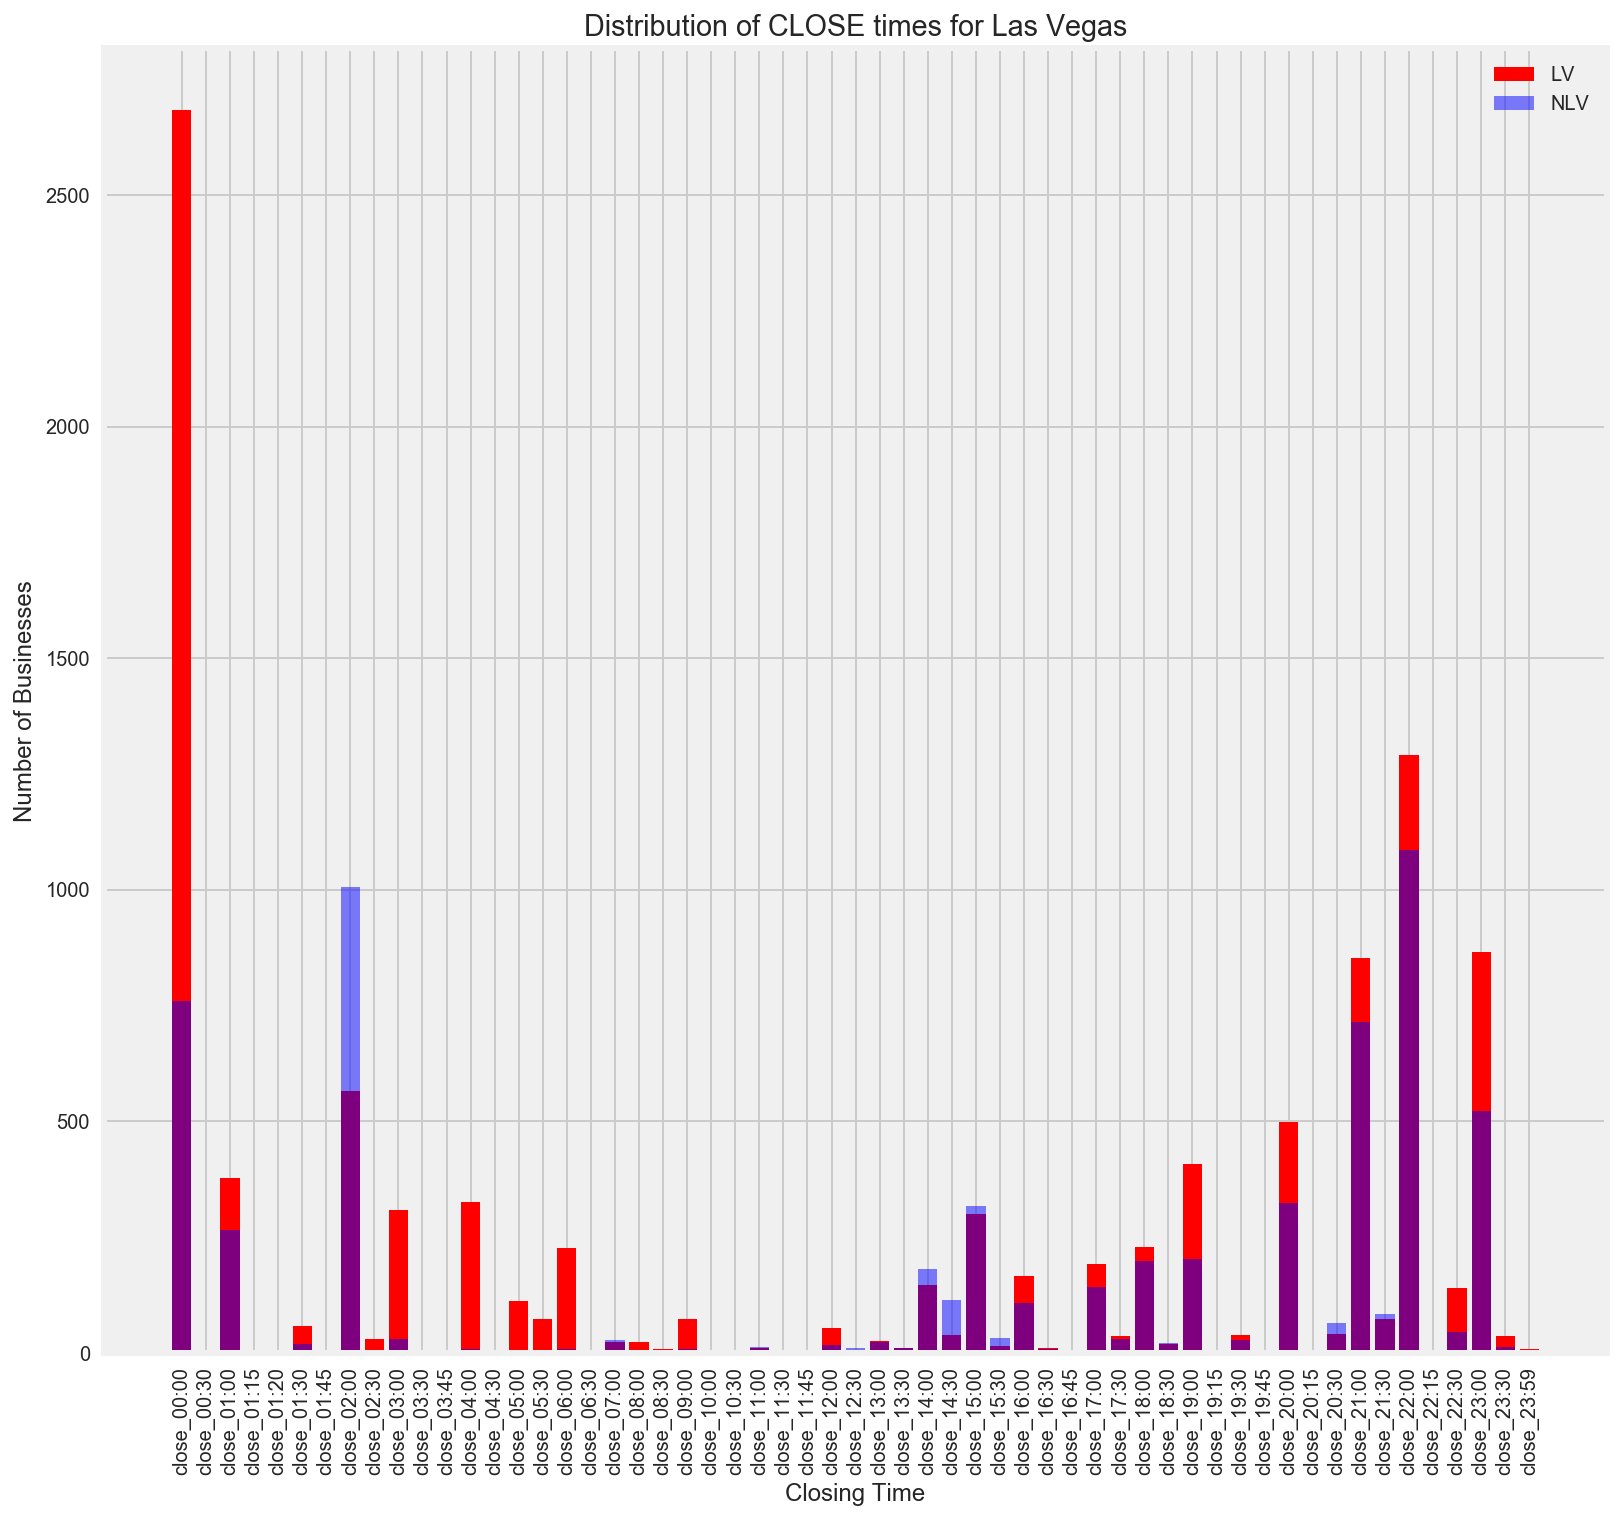

In [36]:
# sns.distplot(open_close_grouped)
plt.figure(figsize=(12,12))

p1 = plt.bar(range(len(open_close_grouped_lv.iloc[:57,:].values)), open_close_grouped_lv.iloc[:57,:].values, color="r", align="center", label='Las Vegas');
p2 = plt.bar(range(len(open_close_grouped_nlv.iloc[:57,:].values)), open_close_grouped_nlv.iloc[:57,:].values, color="b", align="center", alpha=0.5, label='Not Las Vegas');


plt.title("Distribution of CLOSE times for Las Vegas")
plt.legend((p1[0], p2[0]), ('LV', 'NLV'))
plt.xlabel('Closing Time')
plt.ylabel('Number of Businesses')
plt.xticks(range(len(open_close_grouped_lv.iloc[:57,:].values)),open_close_grouped_lv.iloc[:57,:].index ,rotation=90);

Interesting. So a much higher number of LV businesses close at midnight as opposed to NLV businesses. Somehow I don't think that's true. I think it's probably the case the the businesses that are closing at midnight are actually just 24 hour businesses. Why do I think that? Because LV has an extremeley high number of businesses that open at midnight as well, see below...

In [37]:
open_close_grouped_lv.iloc[57:115,:]

,count
index,
open_00:00,1913
open_00:30,7
open_01:00,4
open_03:00,7
open_04:00,10
open_04:30,0
open_05:00,86
open_05:30,45
open_05:45,5


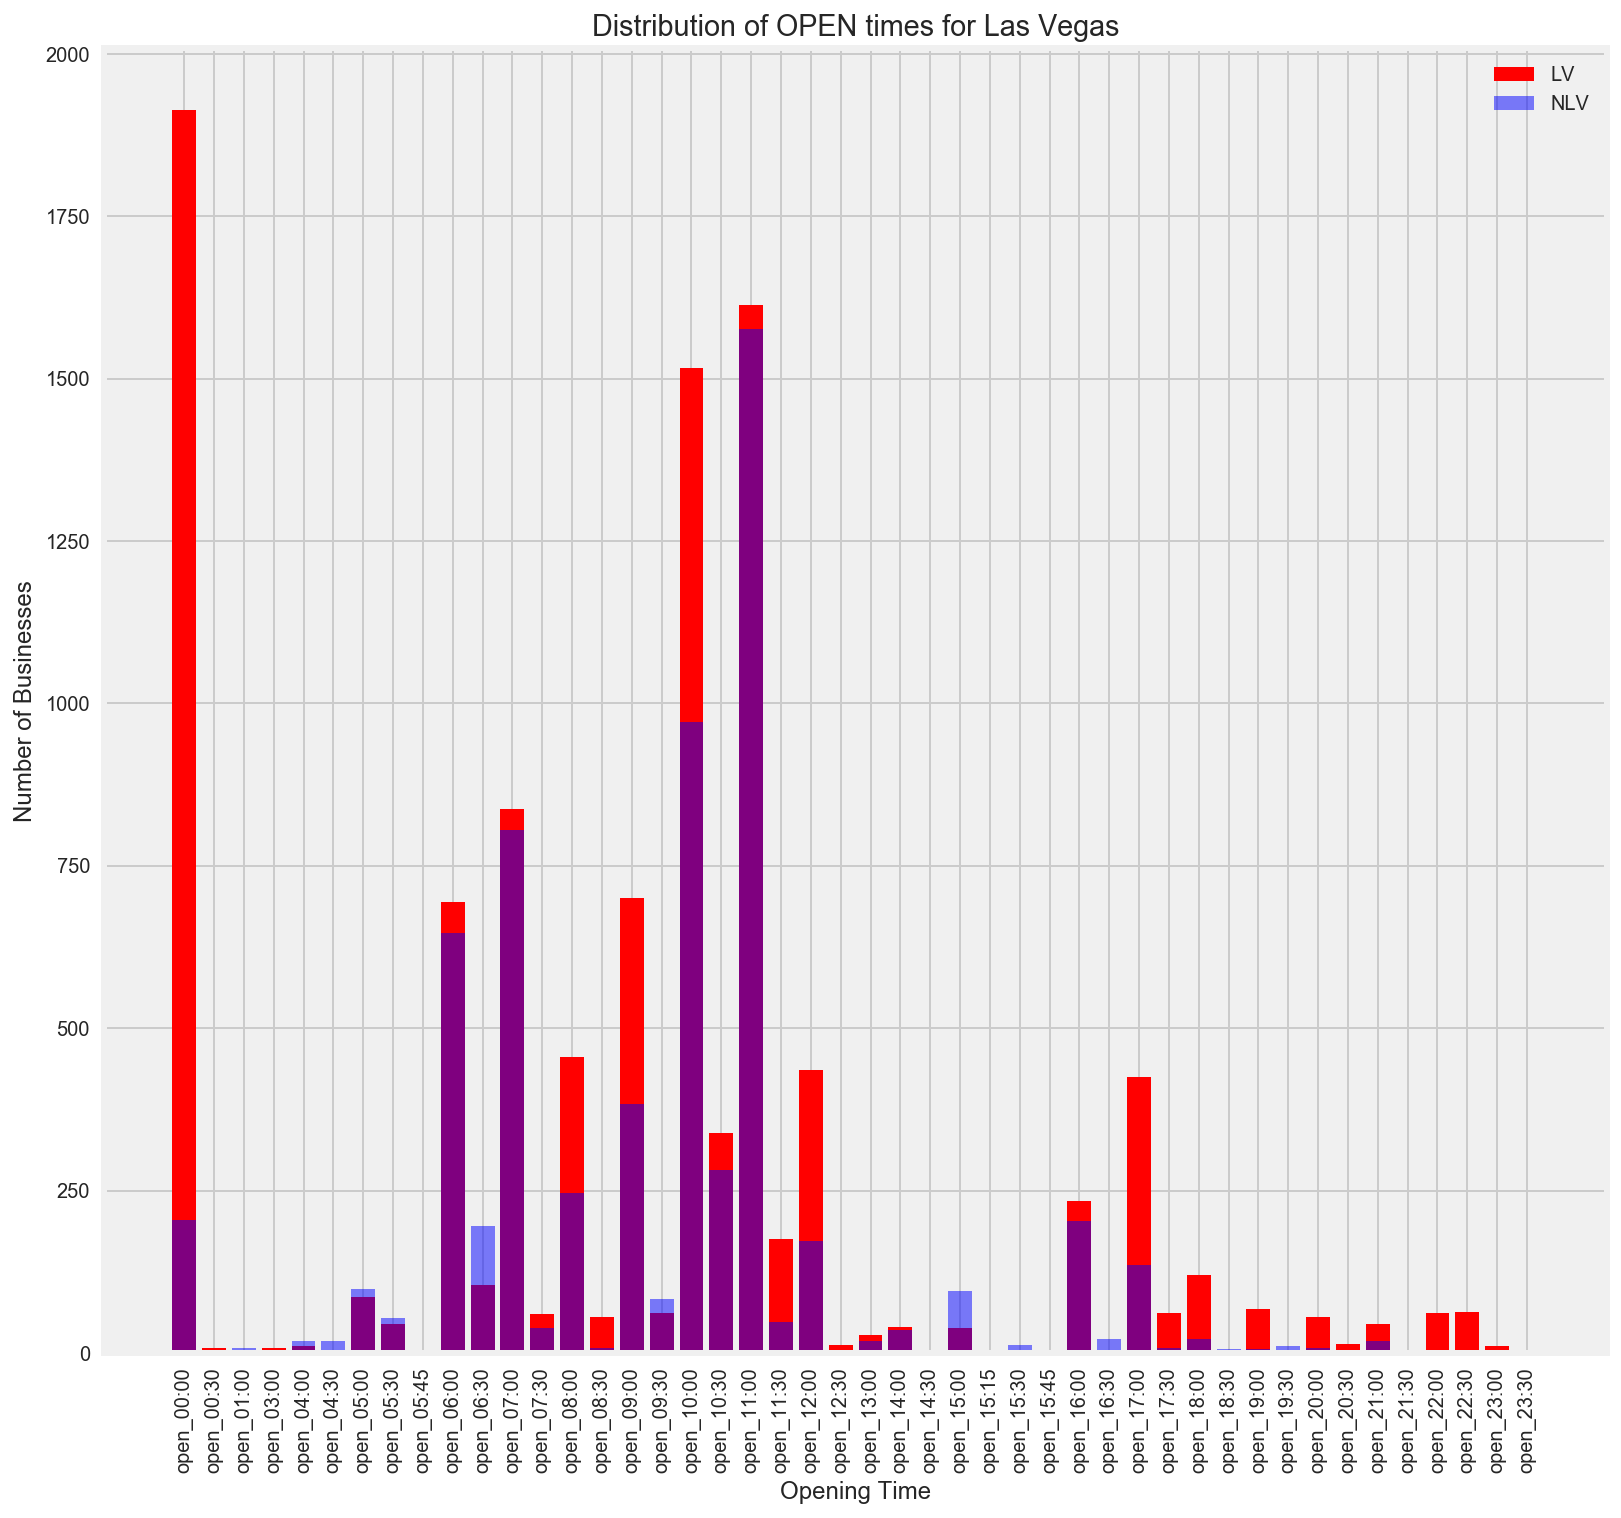

In [38]:
# sns.distplot(open_close_grouped)
plt.figure(figsize=(12,12))

p1 = plt.bar(range(len(open_close_grouped_lv.iloc[57:115,:].values)), open_close_grouped_lv.iloc[57:115,:].values, color="r", align="center", label='Las Vegas');
p2 = plt.bar(range(len(open_close_grouped_nlv.iloc[57:115,:].values)), open_close_grouped_nlv.iloc[57:115,:].values, color="b", align="center", alpha=0.5, label='Not Las Vegas');


plt.title("Distribution of OPEN times for Las Vegas")
plt.legend((p1[0], p2[0]), ('LV', 'NLV'))
plt.xlabel('Opening Time')
plt.ylabel('Number of Businesses')
plt.xticks(range(len(open_close_grouped_lv.iloc[57:115,:].values)),open_close_grouped_lv.iloc[57:115,:].index ,rotation=90);

The large number of open and close times for las vegas businesses seems fishy, but since it's unique to las vegas, I think a closing or opening time of 00:00 would be a good factor. It seems like my hypothesis of making a 'late night businesses' feature won't work though, because the distribution of businesses that close late in the night is pretty even across both LV cities and non-LV cities. 

In [39]:
# late_night_times = ['02:30','03:00','04:00', '05:00','05:30','06:00','06:30','07:00']
# late_night_cols = []

# for col in dfv.columns.tolist()[151:-3]: # open/close cols
#     time = col.split('.')[2].split('_') 
#     if time[0] == 'close':
#         if time[1] in late_night_times:
#             late_night_cols.append(col)

In [40]:
# dfv[late_night_cols].apply(lambda x: 1==x.values, axis=0)
# dfv[late_night_cols].all(axis=1)
# dfv[dfv[late_night_cols].applymap(lambda x: True if x==1 else False).all(axis=1)]

Is there a higher proportion of bars in vegas?

In [41]:
print '% vegas bars:', dfv[dfv['Bars']==1].count()[0] / dfv.shape[0]
print '% vegas bars:', dfnv[dfnv['Bars']==1].count()[0] /dfnv.shape[0]

% vegas bars: 0.347081712062
% vegas bars: 0.295134443022


Yes there is, but not much. 

In [42]:
print dfv[dfv['attributes.Open 24 Hours_True']==1].count()[0]
print dfnv[dfnv['attributes.Open 24 Hours_True']==1].count()[0]

10
0


Maybe we can also see if there are more 24 hour businesses in vegas. 24 hour would have no open or close time at all (I think, we'd have to check if such a business exists). But I'm not going to do that now. 

### Modeling 
---

In [43]:
business_cleaned.columns.tolist()

['business_id',
 'name',
 'review_count',
 'stars',
 'Airports',
 'Breakfast & Brunch',
 'Bubble Tea',
 'Burgers',
 'Bars',
 'Bakeries',
 'Breweries',
 'Cafes',
 'Candy Stores',
 'Comedy Clubs',
 'Courthouses',
 'Dance Clubs',
 'Fast Food',
 'Museums',
 'Tattoo',
 'Vape Shops',
 'Yoga',
 'attributes.Accepts Credit Cards_False',
 'attributes.Accepts Credit Cards_True',
 'attributes.Accepts Insurance_False',
 'attributes.Ages Allowed_18plus',
 'attributes.Ages Allowed_21plus',
 'attributes.Ages Allowed_allages',
 'attributes.Alcohol_beer_and_wine',
 'attributes.Alcohol_full_bar',
 'attributes.Alcohol_none',
 'attributes.Ambience.casual_False',
 'attributes.Ambience.casual_True',
 'attributes.Ambience.classy_False',
 'attributes.Ambience.classy_True',
 'attributes.Ambience.divey_False',
 'attributes.Ambience.divey_True',
 'attributes.Ambience.hipster_False',
 'attributes.Ambience.hipster_True',
 'attributes.Ambience.intimate_False',
 'attributes.Ambience.intimate_True',
 'attributes.Ambie

In [167]:
predictor_cols = business_cleaned.columns.tolist()[3:-1]
target_cols = business_cleaned.columns.tolist()[-1]

X = business_cleaned[predictor_cols].values
y = np.ravel(business_cleaned[target_cols].values)

In [168]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=1)

print X_train
print y_train


[[ 2.5  0.   0.  ...,  0.   1.   0. ]
 [ 4.   0.   0.  ...,  0.   1.   0. ]
 [ 5.   0.   0.  ...,  0.   0.   1. ]
 ..., 
 [ 3.   0.   0.  ...,  0.   0.   1. ]
 [ 4.   0.   0.  ...,  0.   0.   1. ]
 [ 2.5  0.   0.  ...,  0.   0.   1. ]]
[1 1 0 ..., 0 1 1]


In [158]:
print 'baseline precision:', y_train.sum()/y_train.shape[0]

baseline accuracy: 0.619986168741


#### Random Forest

In [159]:
# Set the parameters of the estimator model to scan over 
params = {
    'n_estimators': [500], # number of trees in the forest
    'min_samples_leaf':[30, 50]
}

rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50) 

# create grid search CV 
gs = GridSearchCV(estimator=rfc, param_grid=params, scoring='precision')
# fit model 
gs.fit(X_train, y_train)
# gs.cv_results_
print gs.best_score_, gs.best_params_
best_random_forest_params = gs.best_params_
# score 
# gs.score(X_test, y_test)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [500], 'min_samples_leaf': [30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=0)

0.664218662816 {'n_estimators': 500, 'min_samples_leaf': 30}


In [160]:
print 'best accuracy with random forest:', gs.best_score_

best accuracy with random forest: 0.664218662816


In [161]:
rfc = RandomForestClassifier(n_estimators=500, min_samples_leaf=30) 
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [169]:
from sklearn.metrics import classification_report

y_pred = rfc.predict(X_holdout)

print classification_report(y_holdout, y_pred, digits=4)

             precision    recall  f1-score   support

          0     0.6864    0.2505    0.3671       463
          1     0.6760    0.9318    0.7835       777

avg / total     0.6799    0.6774    0.6280      1240



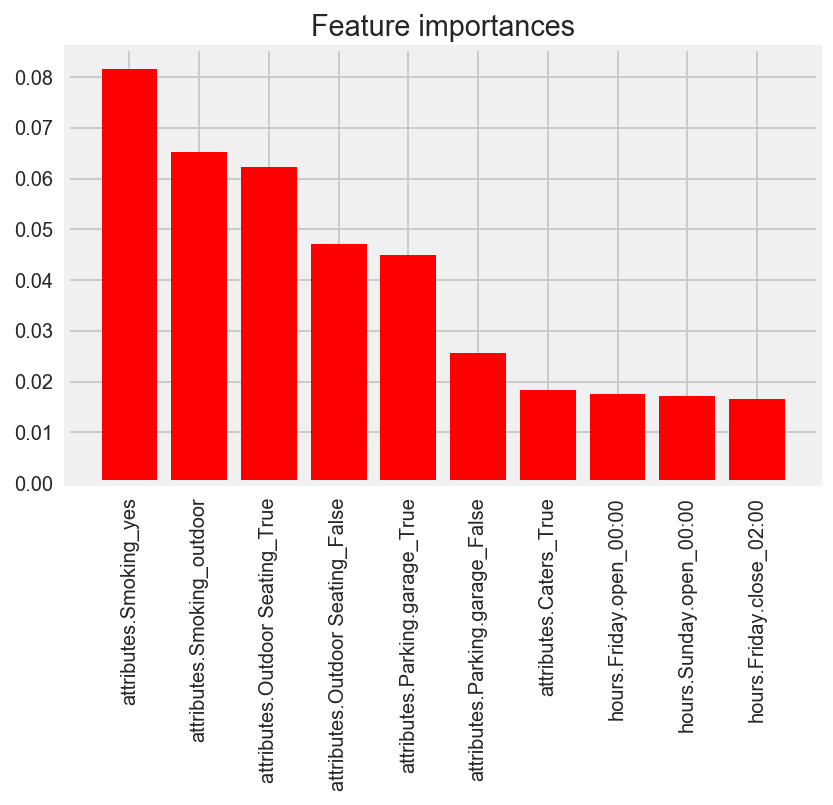

In [49]:
top_10_predictors = sorted(zip(rfc.feature_importances_, predictor_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

**Conclusion**

Seems like the largest factor to a business' location being classified as Las Vegas is 'SMoking' == yes, which funny enough kind of makes sense. Outdoor seating, outdoor smoking, and having a  parking garage were also big factors for las vegas, which I think makes sense - a lot of people except to be able to smoke wherever in vegas, and the high density of shops/casinos/businesses on the strip means you need a lot of parking garages. 

We decided to move on from this question after putting in around 6 hours, but if I were to move forward I would do some feature engineering., IN particular I would see which businesses are open  late during weekdays, because I think vegas businesses would be more likely to be open all hours. Also, I would use k-means clustering to figure this out. 

#### Boosted Random Forest 

In [50]:
# XGB = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)

# learning_rate = [0.3]

# param_grid = dict(learning_rate=learning_rate)

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)

# grid_search = GridSearchCV(XGB, param_grid, scoring="accuracy", n_jobs=3, cv=kfold)

# grid_result = grid_search.fit(X_train, y_train)

# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# y_hat = grid_search.predict(X_holdout)

# pd.crosstab(y_holdout,y_hat, rownames=['Actual'], colnames=['Predicted'], margins=True)

Tried a gradient boosted decision tree, but that didn't work out well. 

In [51]:
print tips.shape, tips.columns
tips.describe()

(101991, 104) Index([u'user_id', u'business_id', u'likes', u'date', u'24 hours',
       u'amazing food', u'animal style', u'awesome food', u'awesome place',
       u'awesome service',
       ...
       u'service good', u'service great', u'slow service', u'staff friendly',
       u'staff great', u'steak eggs', u'super friendly', u'sweet potato',
       u'velvet pancakes', u'worth wait'],
      dtype='object', length=104)


,likes,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,delicious food,don come,don forget,...,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
count,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.00000,101991.000000,...,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000,101991.000000
mean,0.015403,0.001481,0.002432,0.002128,0.002226,0.001304,0.001245,0.001245,0.002216,0.002275,0.001422,0.001382,0.001843,0.002961,0.002412,0.001559,0.001461,0.002118,0.001265,0.001275,0.001422,0.005589,0.001451,0.00153,0.001500,...,0.002030,0.001912,0.001363,0.001951,0.001804,0.001461,0.001363,0.001804,0.003285,0.001892,0.003177,0.001402,0.004481,0.003814,0.002539,0.002373,0.004167,0.001883,0.001549,0.001441,0.001500,0.001471,0.002549,0.002039,0.001784
std,0.137377,0.038449,0.049251,0.047544,0.047332,0.036088,0.035266,0.035543,0.047229,0.047640,0.038196,0.037156,0.042894,0.055230,0.050042,0.039453,0.038450,0.046396,0.035542,0.035679,0.038451,0.075464,0.038066,0.03908,0.038703,...,0.045223,0.043684,0.048793,0.044351,0.042436,0.038194,0.037157,0.042436,0.057218,0.043685,0.057138,0.038706,0.067519,0.062900,0.050329,0.048854,0.064570,0.043347,0.039329,0.037937,0.039206,0.038322,0.050620,0.045114,0.042206
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [52]:
tips.head(3)

,user_id,business_id,likes,date,24 hours,amazing food,animal style,awesome food,awesome place,awesome service,beef hash,beer selection,best breakfast,best burger,best burgers,best place,bloody mary,bottle service,carne asada,cheese fries,chicken waffles,come early,cool place,corned beef,customer service,...,new favorite,nice place,nom nom,onion rings,open 24,place awesome,place eat,place good,place great,potato fries,pretty good,prime rib,really good,red velvet,service food,service good,service great,slow service,staff friendly,staff great,steak eggs,super friendly,sweet potato,velvet pancakes,worth wait
0,trdsekNRD-gIs50EBrScwA,EmzaQR5hQlF0WIl24NxAZA,0,2012-02-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,liIQCDzDTnvXc7X8twBIjg,EmzaQR5hQlF0WIl24NxAZA,0,2013-04-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,iW1ltQqq4GWAErobLiOv9w,EmzaQR5hQlF0WIl24NxAZA,0,2013-08-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
print reviews.columns, reviews.shape
reviews.head()

Index([u'user_id', u'review_id', u'votes.cool', u'business_id', u'votes.funny',
       u'stars', u'date', u'votes.useful', u'10 minutes', u'15 minutes',
       ...
       u'service great', u'staff friendly', u'super friendly', u'sweet potato',
       u'tasted like', u'time vegas', u'try place', u've seen', u've tried',
       u'wait staff'],
      dtype='object', length=108) (322398, 108)


,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,best ve,bloody mary,bottle service,chicken waffles,customer service,dance floor,decided try,definitely come,definitely recommend,didn want,don know,...,pretty good,quality food,really enjoyed,really good,really like,really nice,recommend place,red velvet,right away,saturday night,second time,service excellent,service food,service friendly,service good,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
print users.shape, users.columns
users.head()

(144206, 21) Index([u'yelping_since', u'compliments.plain', u'review_count',
       u'compliments.cute', u'compliments.writer', u'fans',
       u'compliments.note', u'compliments.hot', u'compliments.cool',
       u'compliments.profile', u'average_stars', u'compliments.more', u'elite',
       u'name', u'user_id', u'votes.cool', u'compliments.list', u'votes.funny',
       u'compliments.photos', u'compliments.funny', u'votes.useful'],
      dtype='object')


,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,3.60,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,3.80,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,3.58,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,4.02,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

In [55]:
np.sum(reviews['user_id'].value_counts().sort_values(ascending=True) > 5)
np.sum(reviews['user_id'].value_counts().sort_values(ascending=True) <= 5)

135377

## 1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
---

**Make predictor cols**

In [56]:
reviews_cols = reviews.columns.tolist()
reviews_cols = reviews_cols[0:2] + [reviews_cols[2]] + [reviews_cols[4]] + reviews_cols[7:] + [reviews_cols[5]]
reviews_cols

['user_id',
 'review_id',
 'votes.cool',
 'votes.funny',
 'votes.useful',
 '10 minutes',
 '15 minutes',
 '20 minutes',
 '30 minutes',
 'bar food',
 'beer selection',
 'best ve',
 'bloody mary',
 'bottle service',
 'chicken waffles',
 'customer service',
 'dance floor',
 'decided try',
 'definitely come',
 'definitely recommend',
 'didn want',
 'don know',
 'don like',
 'don think',
 'don want',
 'eggs benedict',
 'fast food',
 'feel like',
 'felt like',
 'fish chips',
 'food amazing',
 'food came',
 'food delicious',
 'food good',
 'food great',
 'food just',
 'food service',
 'french fries',
 'french toast',
 'friday night',
 'fried chicken',
 'friendly staff',
 'good food',
 'good place',
 'good service',
 'good thing',
 'good time',
 'great atmosphere',
 'great experience',
 'great food',
 'great place',
 'great service',
 'great time',
 'happy hour',
 'hash browns',
 'highly recommend',
 'hip hop',
 'ice cream',
 'just like',
 'just ok',
 'just right',
 'las vegas',
 'late night',


In [57]:
reviews_service_cols = []

for col in reviews.columns.tolist():
    if any(x in col for x in ['service','staff','friendly','rude','waiter','minutes']):
        print col
        reviews_service_cols.append(col)

10 minutes
15 minutes
20 minutes
30 minutes
bottle service
customer service
food service
friendly staff
good service
great service
minutes later
service excellent
service food
service friendly
service good
service great
staff friendly
super friendly
wait staff


## 1. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
---

**Create service reviews dataframe**

In [58]:
# Go through every Col in list of service cols and 
reviews_service_indices = []

# Find indices of service oriented reviewers
for col in reviews_service_cols:
    reviews_service_indices.extend(reviews.loc[reviews[col].isin([1]), col].index.values.tolist())
    
reviews_service_indices = sorted(list(set(reviews_service_indices))) # get rid of duplicates?? and sort

reviews_service = reviews.loc[reviews_service_indices, :]

reviews_service = reviews_service[reviews_cols]

reviews_service.head(3)

,user_id,review_id,votes.cool,votes.funny,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,best ve,bloody mary,bottle service,chicken waffles,customer service,dance floor,decided try,definitely come,definitely recommend,didn want,don know,don like,don think,don want,...,quality food,really enjoyed,really good,really like,really nice,recommend place,red velvet,right away,saturday night,second time,service excellent,service food,service friendly,service good,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,stars
7,PnsKyueIKIIimnRGo0niWw,oOYyD6oLLKPm-lj9H9whSw,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
18,tm3vOevmVh6EQlcWNV6Xug,e3LPy75TialrhqsRMH0PYw,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5
23,0mT_KB9dj3M_uOpRikzG3A,rspkxiNHRWLL0I3YJfHlLg,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4


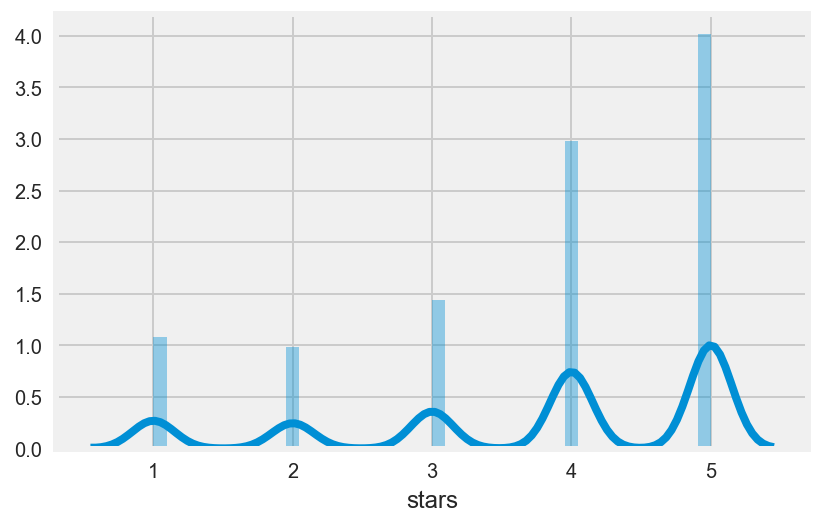

In [59]:
sns.distplot(reviews_service['stars'])

There's a lot more 5's than any other class, so this is unbalanced. Classification might not do so great without some rebalancing....

** Create non service reviews dataframe**

In [60]:
# Create reviews dataframe for non-service oriented users
# find user_id that are in reviews but not in reviews_service
reviews_indices = reviews.index.values

# Remove the reviews_service_indices from the total reviews–indices
reviews_non_service_indices = list(set(reviews_indices) - set(reviews_service_indices))

reviews_non_service = reviews.iloc[reviews_non_service_indices, :]


reviews_non_service = reviews_non_service[reviews_cols]

reviews_non_service.head(3)

,user_id,review_id,votes.cool,votes.funny,votes.useful,10 minutes,15 minutes,20 minutes,30 minutes,bar food,beer selection,best ve,bloody mary,bottle service,chicken waffles,customer service,dance floor,decided try,definitely come,definitely recommend,didn want,don know,don like,don think,don want,...,quality food,really enjoyed,really good,really like,really nice,recommend place,red velvet,right away,saturday night,second time,service excellent,service food,service friendly,service good,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff,stars
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,12,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


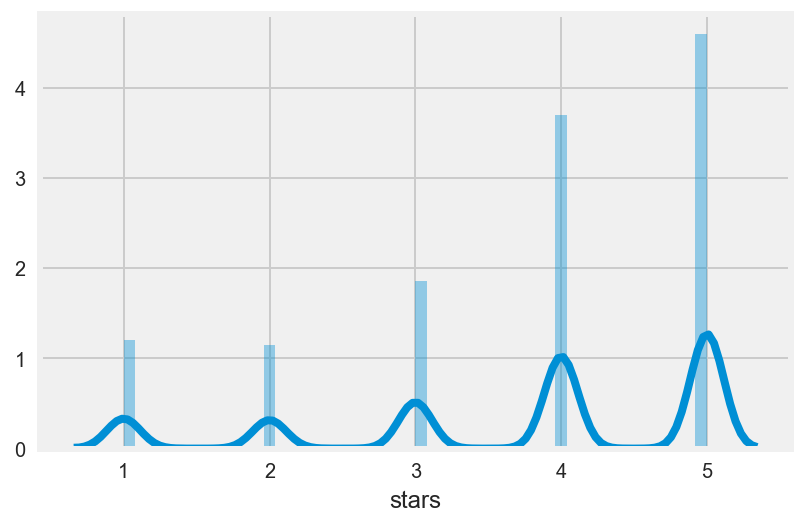

In [61]:
sns.distplot(reviews_non_service['stars'])

Both dataframes are imbalanced . 

** Make 2 columsn in business dataframe, 1 for average service customer review, and 1 for average non-service customer review** i.e.Creating stars.service and stars.non_service in business_copy

In [62]:
# # group the reviews_service dataframe by business_id, and aggregate the ratings column using np.mean() 
# # to find the average rating for a business from service oriented customers
# reviews_service_grouped = reviews_service.groupby(by='business_id')['stars'].agg(np.mean).reset_index()
# reviews_service_grouped.rename(columns={'stars':'stars.service_customers'}, inplace=True) # rename stars column

# # do the same for non-service oriented reviews
# reviews_non_service_grouped = reviews_non_service.groupby(by='business_id')['stars'].agg(np.mean).reset_index()
# reviews_non_service_grouped.rename(columns={'stars':'stars.non_service_customers'}, inplace=True) # rename stars column

# # merge the grouped df with business dataframe
# business_merged = pd.merge(left=business_copy, right=reviews_service_grouped, how='inner', on='business_id')
# business_merged = pd.merge(left=business_merged, right=reviews_non_service_grouped, how='inner', on='business_id')

# # check if merge was successful 
# # print reviews_service_grouped[reviews_service_grouped['business_id']=='-1bOb2izeJBZjHC7NWxiPA']#.loc[:, 'stars.service_customers']
# # print business_merged[business_merged['business_id']=='-1bOb2izeJBZjHC7NWxiPA'].loc[:, 'stars.service_customers']

Wait I realized I didn't need to do that...

### 2. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice).
---

Now I'm using business merged, but then I realized I didn't have to use the business dataframe... so this is all bogus.

In [63]:
# business_merged = business_merged.drop_duplicates('business_id')

# drop variable, value columns and also 

# business_merged.drop(labels=['variable','value'], axis=1, inplace=True)

# business_merged.head(2)

# Rearrange columns to put city last

# predictor_cols = business_merged.columns.tolist()[-19:-2]
# predictor_cols.insert(0, 'review_count')
# target_service = 'stars.service_customers'
# target_non_service = 'stars.non_service_customers'

# X = business_merged[predictor_cols].values
# y_s = np.ravel(business_merged[target_service].values)
# y_n = np.ravel(business_merged[target_non_service].values)

# from sklearn.model_selection import train_test_split

# X_train, X_test, y_s_train, y_s_test, y_n_train, y_n_test = train_test_split(X, y_s, y_n, test_size=0.3, random_state=1) 

# print y_s_test.shape
# print y_s_hat.shape

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_val_score

# rfr = RandomForestRegressor()
# scores = cross_val_score(estimator=RandomForestRegressor(), X=X, y=y_s, cv=10, scoring='r2')
# print np.mean(scores)

# from sklearn.linear_model import LinearRegression
# # lms = LinearRegression()
# # lms.fit(X_train,y_s_train)
# # y_s_hat = lms.predict(X_test)

# scores = cross_val_score(estimator=LinearRegression(), X=X, y=y_s, cv=10, scoring='r2')
# print np.mean(scores)

# # lms = LinearRegression()
# # lms.fit(X_train,y_s_train)
# # y_s_hat = lms.predict(y_s_test)

In [64]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


### Regression

**Service Reviews data**

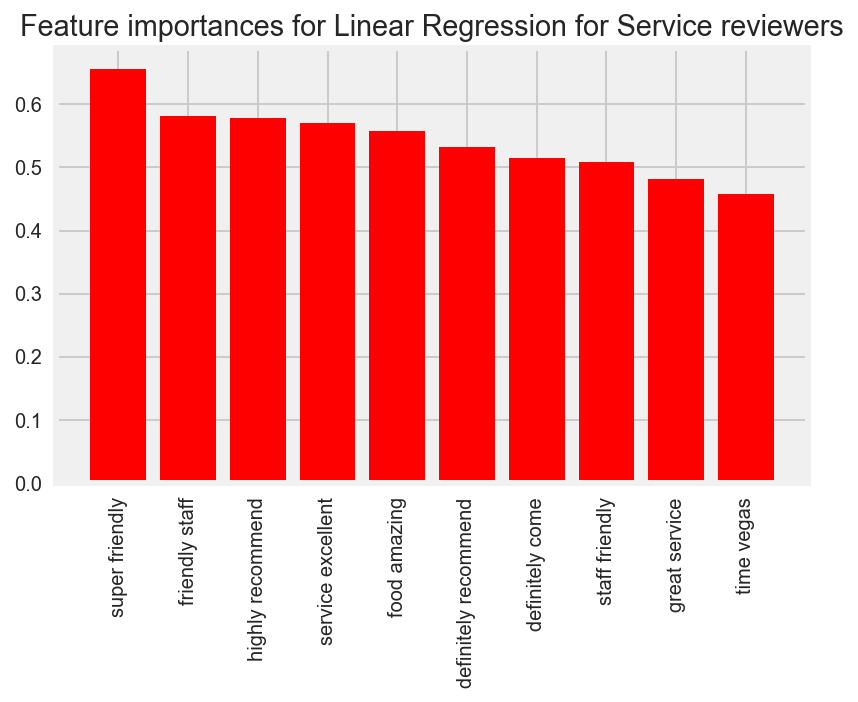

In [65]:
X = reviews_service.iloc[:, 2:-1].values 
X_cols = reviews_service.iloc[:, 2:-1].columns.tolist()
y = np.ravel(reviews_service.iloc[:, -1].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

lr = LinearRegression()

lr.fit(X_train, y_train)

y_hat_lr  = lr.predict(X_test)

y_hat_lr = np.array([int(round(x, 0)) for x in y_hat_lr])

lr.score(X_test, y_hat_lr)

top_10_predictors = sorted(zip(lr.coef_, X_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Linear Regression for Service reviewers")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

**Non Service Reviews data**


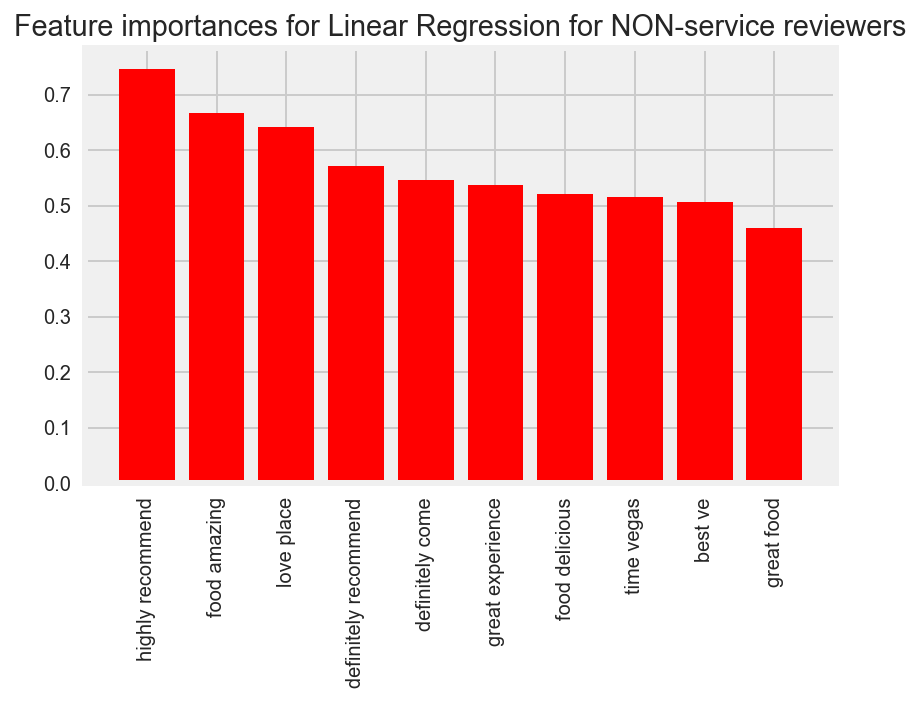

In [66]:
X = reviews_non_service.iloc[:, 2:-1].values 
X_cols = reviews_non_service.iloc[:, 2:-1].columns.tolist()
y = np.ravel(reviews_non_service.iloc[:, -1].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) 

lr = LinearRegression()

lr.fit(X_train, y_train)

y_hat_lr  = lr.predict(X_test)

y_hat_lr = np.array([int(round(x, 0)) for x in y_hat_lr])

lr.score(X_test, y_hat_lr)

top_10_predictors = sorted(zip(lr.coef_, X_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances for Linear Regression for NON-service reviewers")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

**Conclusion based on Linear regression**  The top 10 features of service customers include 5 mentions of service. Out of The top 10 features for non-service reviewer none mention service. although I wouldn't call this a comphrenesive study into the question, our cursory overview into the question leads us to believe that the two reviewers are different, or in other words, the most important factors that determine how a user is going to rate a restaurant are actually different between non-customer service oriented reviews and customer service oriented reviews. This suggests that there are two different types of reviewers - those who care about service, and those who don't care about service as much when rating a restaurant. 

### Multiclass classification

**Service Reviews dataframe**

In [67]:
X = reviews_service.iloc[:, 2:-1].values 
X_cols = reviews_service.iloc[:, 2:-1].columns.tolist()
y = np.ravel(reviews_service.iloc[:, -1].values)

random forest regression

In [68]:
# rfr = RandomForestRegressor(n_estimators=100, min_samples_leaf=50)

# # Set the parameters of the estimator model to scan over 
# params = {
#     'n_estimators': [10], # number of trees in the forest
#     'min_samples_leaf':[50]
# }


# gs = GridSearchCV(estimator=rfr, param_grid=params, scoring='r2', cv=3, verbose=1)

# gs.fit(X, y)

# print gs.best_params_ 

# gs.best_score_

That's horrible. I think a multi-class classification is better for this since our target is a rating from 1-5. 

**Multiclass Logistic Regression**

Decided to user a multiclass logistic classifier instead of a linear regression, and see if that accuractely predicts star rating. 

In [69]:
# for multi_class in ('multinomial', 'ovr'):
#     clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
#                              multi_class=multi_class).fit(X, y)

#     # print the training scores
#     print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))


In [70]:
clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class='multinomial')
clf.fit(X, y)
y_hat = clf.predict(X)

print y_hat
print y
# print clf.score(y_hat.reshape(-1,1), y.reshape(-1,1))

[1 5 3 ..., 5 5 5]
[2 5 4 ..., 5 4 5]


/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


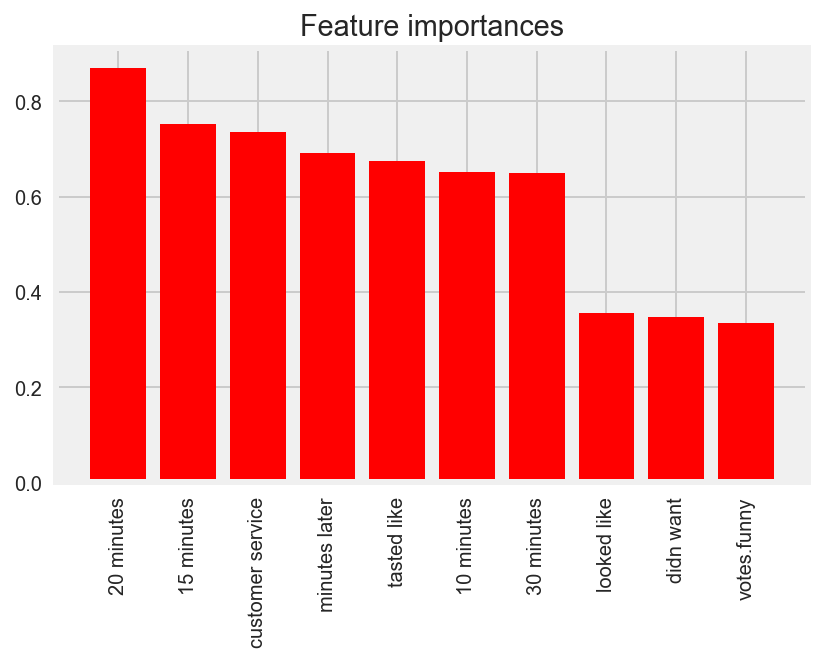

In [71]:
# For 1 star
clf.coef_[0]

top_10_predictors = sorted(zip(clf.coef_[0], X_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

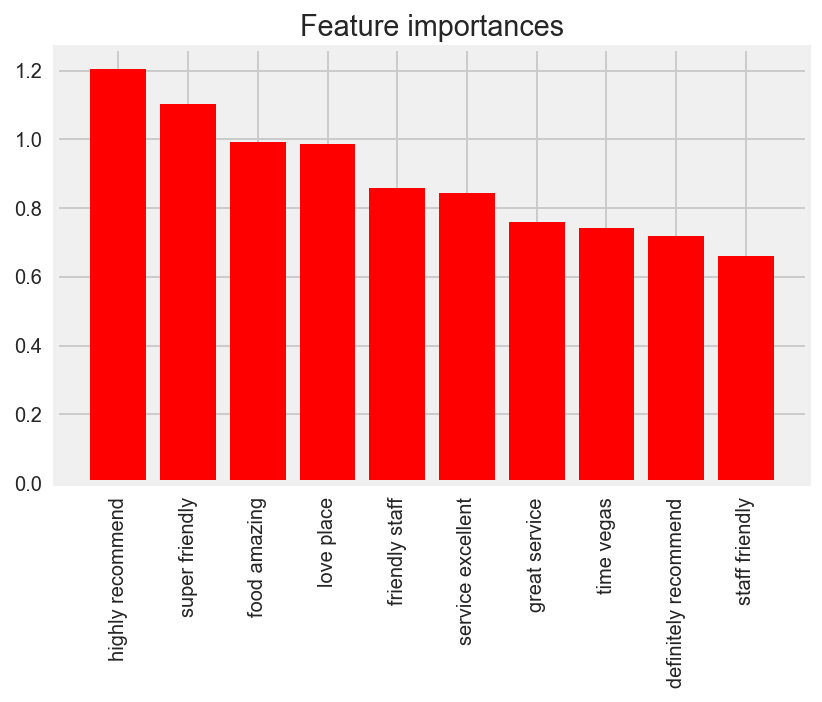

In [72]:
# For 5 star
clf.coef_[4]

top_10_predictors = sorted(zip(clf.coef_[4], X_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

When rating highly, the 'service' oriented customers, mention service 5 times in the top 10 features. That's significant I'd say. 

**Non Service Reviews dataframe**

In [73]:
X = reviews_non_service.iloc[:, 2:-1].values
X_cols = reviews_non_service.iloc[:, 2:-1].columns.tolist()
y = np.ravel(reviews_non_service.iloc[:, -1].values)

In [74]:
clf = LogisticRegression(solver='sag', max_iter=100, random_state=42, multi_class='multinomial')
clf.fit(X, y)
y_hat = clf.predict(X)

print y_hat
print y
# print clf.score(y_hat.reshape(-1,1), y.reshape(-1,1))

[5 1 5 ..., 5 5 5]
[3 2 2 ..., 5 5 5]


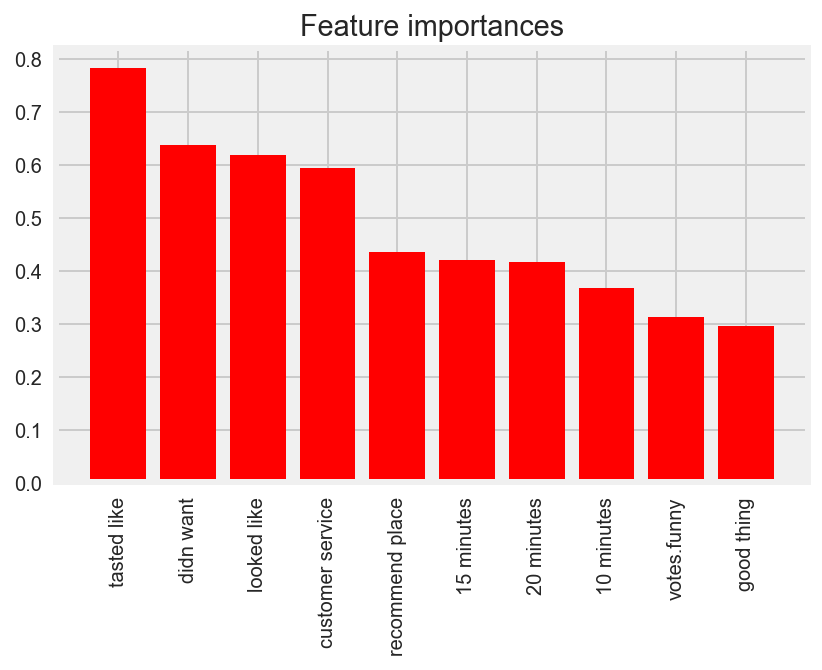

In [75]:
clf.coef_[0]

top_10_predictors = sorted(zip(clf.coef_[0], X_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

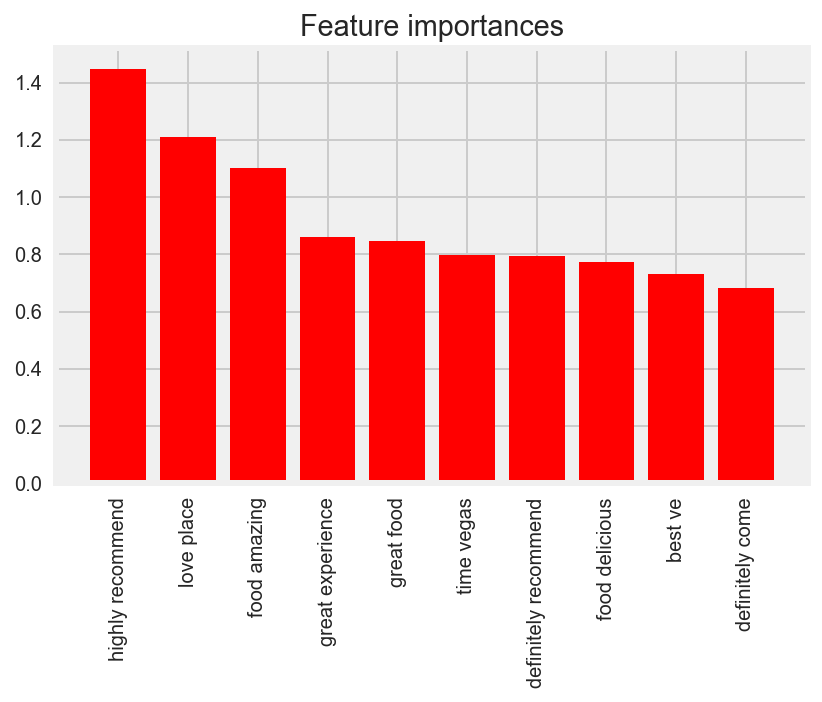

In [76]:
clf.coef_[4]

top_10_predictors = sorted(zip(clf.coef_[4], X_cols), reverse=True)[:10]

top_10_predictors

values = [value for value, predictors in top_10_predictors]
predictors = [predictors for value, predictors in top_10_predictors]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=90);

**Conclusion based on multiclass logistic classification** So we aren't sure if our model is doing a good job of prediction, because we aren't sure how to validate a multi-class model. 

Service features represent 50% of the top 10 features in predicting 5 stars for 'service' oriented customers. 

Service features represented 0% of the top 10 features in predicting 5 stars for 'non-service' oriented customers. 

This suggests the two reviers are really different, or in other words, the most important factors that determine how a user is going to rate a restaurant are significantly different between the customers who mention service in their reviews, and those customers who do not.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


In [177]:
users = pd.read_csv('/Users/Naekid/Desktop/DSI-SF-5-fork/DSI-SF-5/datasets/yelp_arizona_data/users_small_parsed.csv')

In [178]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [179]:
user_unique_user_ids = set(users['user_id'].unique().tolist())
reviews_unique_user_ids = set(reviews['user_id'].unique().tolist())

user_unique_user_ids == reviews_unique_user_ids

True

**NOTES** I think it's possible to combine the reviews dataframe to get more features, but I am just going to start with the users dataframe. 

In [180]:
users.head(1)

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,average_stars,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,3.66,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199


First, I think that we should convert yelping_since to something like "days since singup". That way we can use it as a predictor in our model. I also think that people with a higher "days since signup" count might be more likely to be an elite user. 

In [181]:
def find_days_from_signup(x):
    td = max_datetime - x
    return td.days

In [182]:
import datetime

# Assume they started at the beginning of the month
# users['yelping_since'] = users['yelping_since'].apply(lambda x: x + '-01') # don't need this

yelping_since = pd.to_datetime(users['yelping_since'], format='%Y-%m')

# what's the max 'yelping since' 
max_datetime = max(yelping_since.values)

print 'latest date in yelping_since:', max_datetime

# max_datetime - yelping_since[0]
print type(max_datetime)
print type(yelping_since[0])

max_datetime = datetime.datetime(2015, 12, 1)

users['yelping_since_days'] = yelping_since.map(find_days_from_signup)

latest date in yelping_since: 2015-12-01T00:00:00.000000000
<type 'numpy.datetime64'>
<class 'pandas.tslib.Timestamp'>


In [183]:
print users.shape
print (users.isnull().sum()/users.shape[0]).map(lambda x: round(x,2)).sort_values(ascending=False)

(144206, 22)
compliments.list       0.95
compliments.cute       0.91
compliments.profile    0.91
compliments.photos     0.87
compliments.more       0.83
compliments.funny      0.79
compliments.hot        0.78
compliments.writer     0.77
compliments.note       0.72
compliments.cool       0.72
compliments.plain      0.67
yelping_since_days     0.00
review_count           0.00
fans                   0.00
average_stars          0.00
votes.useful           0.00
elite                  0.00
name                   0.00
user_id                0.00
votes.cool             0.00
votes.funny            0.00
yelping_since          0.00
dtype: float64


We have a TON of missing values in this dataframe... Not sure what to do about that. It might be the case that if a user didn't get any compliments, then they just got an NA. So let's check for that

In [184]:
0.0 in users['compliments.cool'].unique()

False

And that appears to be the case. So we can replace all NA with 0. That will help. 

In [185]:
def check_for_nan(x):
    try:
        if(np.isnan(x)):
            return int(0)
        else:
            return x
    except:
        return x

users = users.applymap(check_for_nan)

print users.isnull().sum()

yelping_since          0
compliments.plain      0
review_count           0
compliments.cute       0
compliments.writer     0
fans                   0
compliments.note       0
compliments.hot        0
compliments.cool       0
compliments.profile    0
average_stars          0
compliments.more       0
elite                  0
name                   0
user_id                0
votes.cool             0
compliments.list       0
votes.funny            0
compliments.photos     0
compliments.funny      0
votes.useful           0
yelping_since_days     0
dtype: int64


Now we need a column that is class 0 if not elite and class 1 if elite. 

In [186]:
users['elite?'] = users['elite'].apply(lambda x: 0 if x=='[]' else 1)

rearange columns

In [187]:
users_cols = users.columns.tolist()
users_cols = sorted(users_cols)

# user_cols.remove('user_id')
# user_cols.remove('name')
# user_cols.remove('yelping_since')
users_cols = [col for col in users_cols if col not in ['user_id','name','yelping_since','elite','elite?']]
users_cols = ['user_id'] + users_cols + ['elite?']

users = users[users_cols]
users.head(1)

,user_id,average_stars,compliments.cool,compliments.cute,compliments.funny,compliments.hot,compliments.list,compliments.more,compliments.note,compliments.photos,compliments.plain,compliments.profile,compliments.writer,fans,review_count,votes.cool,votes.funny,votes.useful,yelping_since_days,elite?
0,rpOyqD_893cqmDAtJLbdog,3.66,1642.0,206.0,580.0,1094.0,38.0,134.0,611.0,330.0,959.0,116.0,327.0,1179,1274,11093,7681,14199,4078,1


### EDA
---

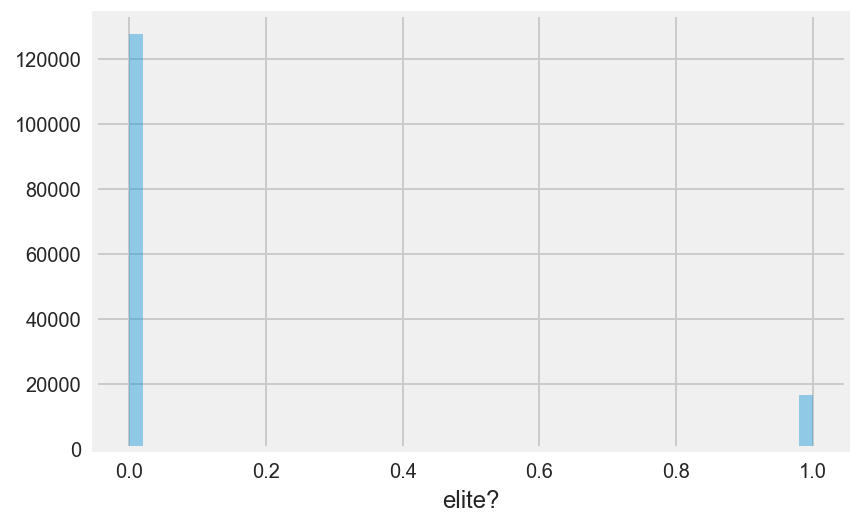

In [188]:
sns.distplot(users['elite?'], kde=False)

We should do some resampling since the classes are extremeley unbalanced. 

In [189]:
users.columns.tolist()

['user_id',
 'average_stars',
 'compliments.cool',
 'compliments.cute',
 'compliments.funny',
 'compliments.hot',
 'compliments.list',
 'compliments.more',
 'compliments.note',
 'compliments.photos',
 'compliments.plain',
 'compliments.profile',
 'compliments.writer',
 'fans',
 'review_count',
 'votes.cool',
 'votes.funny',
 'votes.useful',
 'yelping_since_days',
 'elite?']

In [190]:
# f = pd.melt(users, value_vars=users.columns.tolist()[1:])
# g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
# g = g.map(sns.distplot, "value")

It looks like "yelping_since_days" has a log-normal distribution, so maybe we can make it normal by taking the log!

In [191]:
users['yelping_since_days'] = users['yelping_since_days'] + 1

In [192]:
users['yelping_since_days_log'] = map(lambda x: np.log(x),users['yelping_since_days'].values)
users.head(1)

,user_id,average_stars,compliments.cool,compliments.cute,compliments.funny,compliments.hot,compliments.list,compliments.more,compliments.note,compliments.photos,compliments.plain,compliments.profile,compliments.writer,fans,review_count,votes.cool,votes.funny,votes.useful,yelping_since_days,elite?,yelping_since_days_log
0,rpOyqD_893cqmDAtJLbdog,3.66,1642.0,206.0,580.0,1094.0,38.0,134.0,611.0,330.0,959.0,116.0,327.0,1179,1274,11093,7681,14199,4079,1,8.313607


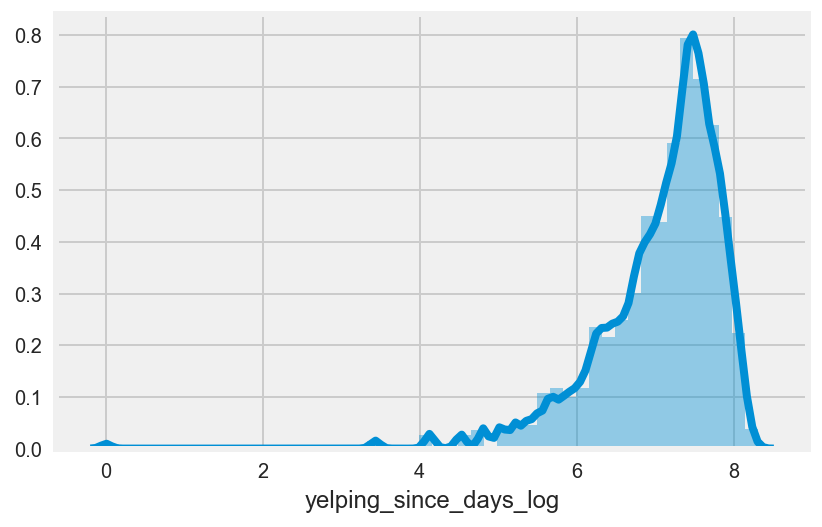

In [193]:
sns.distplot(users['yelping_since_days_log'])

Well thats not normal either so maybe this column won't be of use...

In [194]:
users.drop(labels='yelping_since_days_log', axis=1, inplace=True)

In [195]:
users.columns.tolist()

['user_id',
 'average_stars',
 'compliments.cool',
 'compliments.cute',
 'compliments.funny',
 'compliments.hot',
 'compliments.list',
 'compliments.more',
 'compliments.note',
 'compliments.photos',
 'compliments.plain',
 'compliments.profile',
 'compliments.writer',
 'fans',
 'review_count',
 'votes.cool',
 'votes.funny',
 'votes.useful',
 'yelping_since_days',
 'elite?']

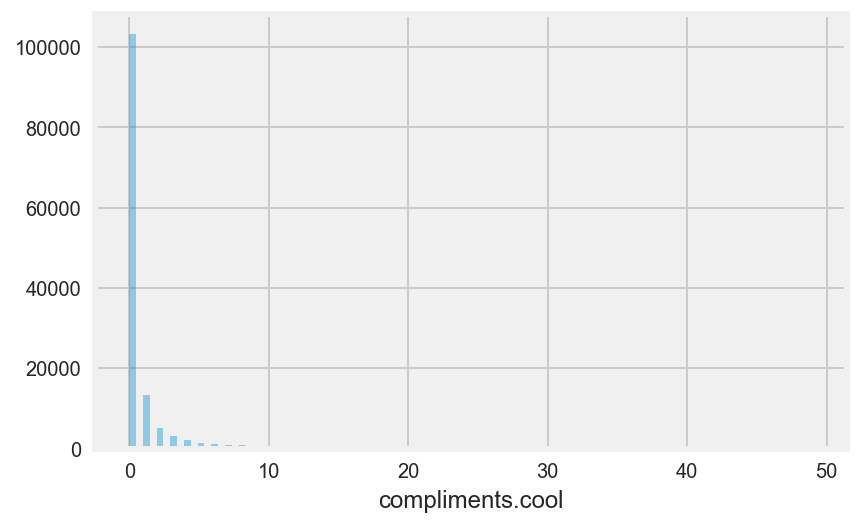

In [196]:
ax = sns.distplot(users[users['compliments.cool'] < 50].iloc[:, 2], kde=False, bins=100)

I mean, now that I know the distribution of compliments.cool, how does that affect my modeling??

**Resampling using SMOTE**

In [197]:
X = users.iloc[:, 1:-1].values
y = users.iloc[:, -1].values

predictor_cols = users.columns.tolist()[1:-1]
target_col = users.columns.tolist()[-1]

In [198]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(kind='svm')
# X_resampled, y_resampled = sm.fit_sample(X, y)


Okay SMOTE didn't work because it took too long

### Modeling
---

In [199]:
#--- TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

In [200]:
np.sum(y_train)/y_train.shape[0] 

0.11599805831975313

That means our baseline is 90%, because if we classified all users as elite, we would get 89% correct. 

In [201]:
#--- Logistic Model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight='balanced')

lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [202]:
print lr.score(X_test, y_test)

0.93960196935


That's better than baseline accuracy. but let's validate with cross val score.

In [203]:
from sklearn.model_selection import cross_val_score
folds = 5
scores = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='precision', cv=folds)
print 'mean precision score over {} folds: '.format(folds), np.mean(scores)

mean precision score over 5 folds:  0.685312789536


That's better than baseline!

In [104]:
from sklearn.model_selection import cross_val_score
folds = 5
scores = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='f1', cv=folds)
print 'mean f1 score over {} folds: '.format(folds), np.mean(scores)

mean f1 score over 5 folds:  0.77629016379


Let's see what happens when we don't balance the classes using the class_weight argument to lostiic regression. 

In [105]:
folds = 5
scores = cross_val_score(estimator=LogisticRegression(), X=X_train, y=y_train, scoring='f1', cv=folds)
print 'mean f1 score over {} folds: '.format(folds), np.mean(scores)

mean f1 score over 5 folds:  0.725295069396


Our score does down. So it's important to add the weights to our model then, because our target ('elite') is unbalanced. 

**Okay so 0.77 f1 score isn't bad. Let's see what the most important features are. **

[(0.14496695413199157, 'fans'), (0.13202530515484723, 'compliments.writer'), (0.10341882310923645, 'compliments.more'), (0.026538068686889901, 'compliments.cool'), (0.022300877713869686, 'review_count'), (0.0054508205461671223, 'votes.cool'), (0.0041321995436308422, 'votes.useful'), (0.0016926512799707793, 'compliments.note'), (-0.00023136667073696865, 'yelping_since_days'), (-0.00085807347400549728, 'compliments.hot'), (-0.0082127698578019943, 'votes.funny'), (-0.008332231984795338, 'compliments.plain'), (-0.016777388040070014, 'compliments.cute'), (-0.023386778583030832, 'compliments.funny'), (-0.035592912136280644, 'compliments.photos'), (-0.039070693727127299, 'compliments.list'), (-0.13318578362147818, 'compliments.profile'), (-0.60712620665110217, 'average_stars')]


<Container object of 18 artists>

([<matplotlib.axis.XTick at 0x11f9c9a10>,
 <a list of 18 Text xticklabel objects>)

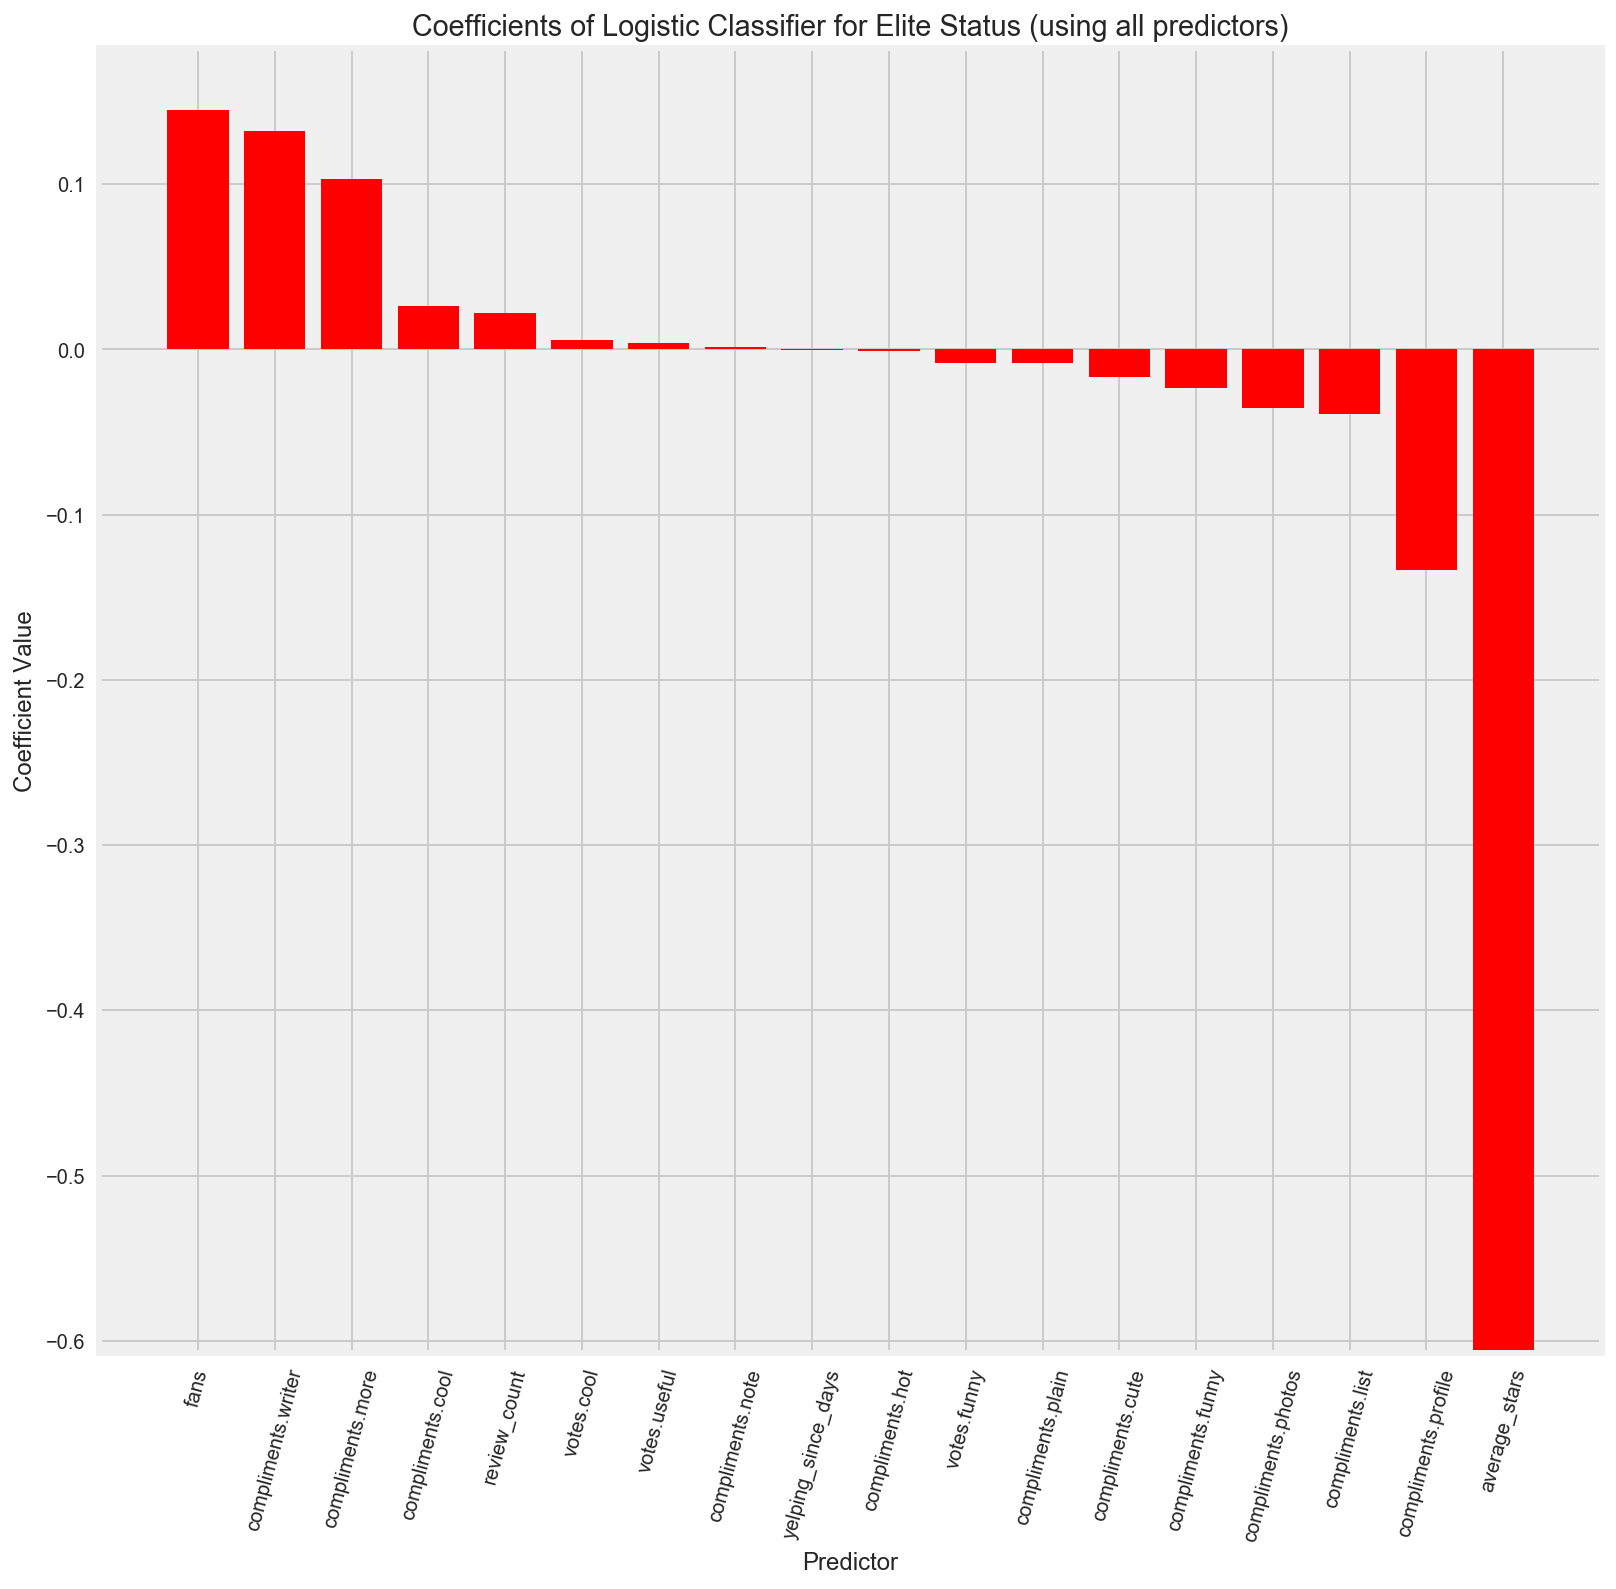

In [106]:
top_predictors = sorted(zip(lr.coef_[0], predictor_cols), reverse=True)

print top_predictors

values = [value for value, predictors in top_predictors]
predictors = [predictors for value, predictors in top_predictors]

# Plot the feature importances of the forest
plt.figure(figsize=(12,12))
plt.title("Coefficients of Logistic Classifier for Elite Status (using all predictors)")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=75);
plt.xlabel('Predictor')
plt.ylabel('Coefficient Value')
plt.savefig('Coefficients of Logistic Classifier for Elite Status (using all predictors).png')

**NOTES** Most significant predictors for an elite user? Number of fans, number of compliments (Good Writer, and Write More, Like your Profile) and average rating. The negative coef for average_stars indicates that the predictor is inverseley associated with the probability of a user being classified elite. So as a user's rating average increases the likelihood that they are elite decreases significantly. 

[(0.60712620665110217, 'average_stars'), (0.14496695413199157, 'fans'), (0.13318578362147818, 'compliments.profile'), (0.13202530515484723, 'compliments.writer'), (0.10341882310923645, 'compliments.more')]


<Container object of 5 artists>

([<matplotlib.axis.XTick at 0x1161cb690>,
 <a list of 5 Text xticklabel objects>)

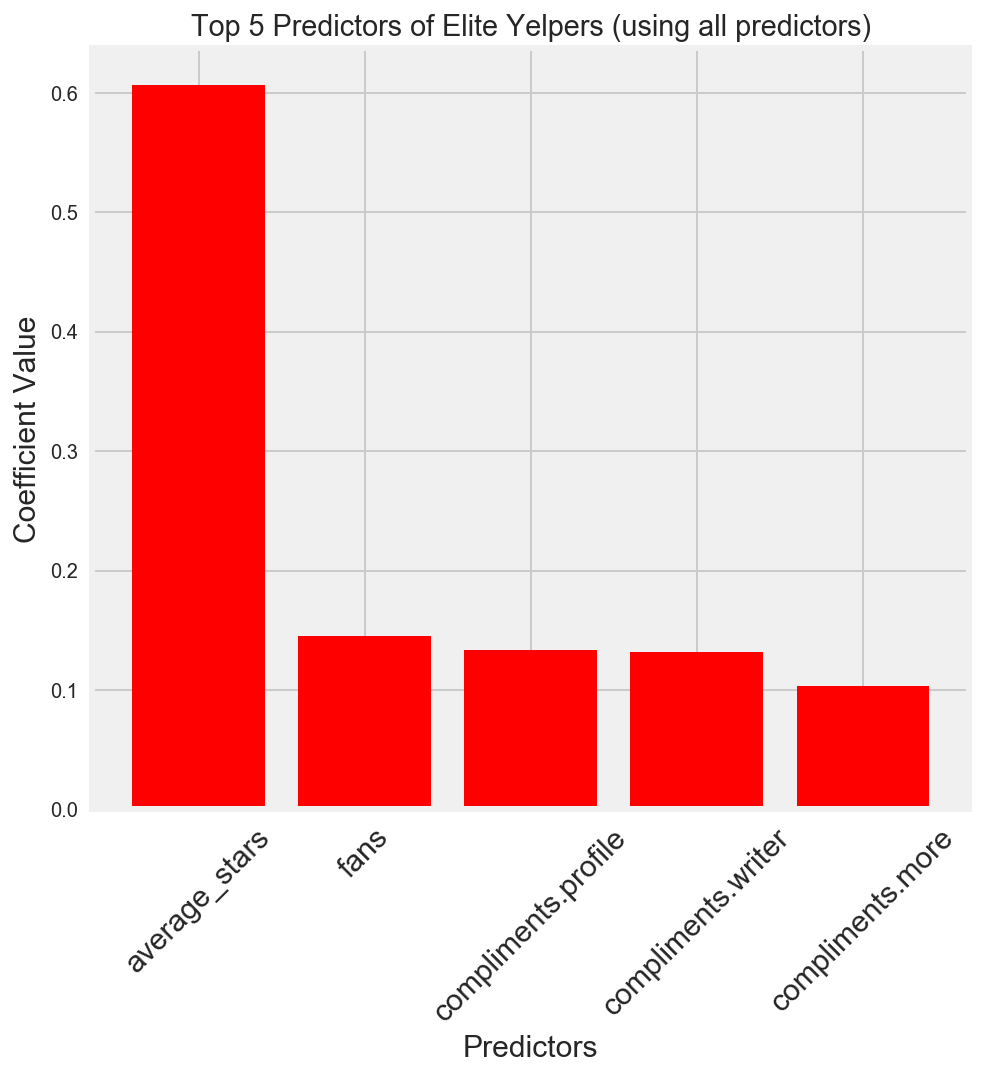

In [107]:
coeffs = lr.coef_[0]
top_5_predictors = sorted(zip(np.abs(coeffs), predictor_cols), reverse=True)[:5]

print top_5_predictors

values = [value for value, predictors in top_5_predictors]
predictors = [predictors for value, predictors in top_5_predictors]

# Plot the feature importances of the forest
plt.figure(figsize=(7,7))
plt.title("Top 5 Predictors of Elite Yelpers (using all predictors)")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=45, fontsize=15);
plt.xlabel('Predictors', fontsize=15)
plt.ylabel('Coefficient Value', fontsize=15)
plt.savefig('Top 5 Predictors of Elite Yelpers (using all predictors).png')

### If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything?

In [108]:
non_count_cols = users.columns.tolist()
non_count_cols = [non_count_cols[1]]+ [non_count_cols[-7]] + non_count_cols[-2:]
users_non_count = users[non_count_cols]

In [109]:
X = users_non_count.iloc[:, :-1].values
y = users_non_count.iloc[:, -1].values

predictor_cols = users_non_count.columns.tolist()[:-1]
target_col = users_non_count.columns.tolist()[-1]

non_count_predictor_cols = users_non_count.columns.tolist()[:-1]
non_count_target_col = users_non_count.columns.tolist()[-1]

In [110]:
#--- TRAIN TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

In [111]:
from sklearn.model_selection import cross_val_score
folds = 5
scores = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='f1', cv=folds)
print 'mean f1 score over {} folds: '.format(folds), np.mean(scores)

mean f1 score over 5 folds:  0.718388613694


0.71 is not as good as 0.77. Let's try without 'yelping_since_days'.

In [112]:
non_count_cols = users.columns.tolist()
non_count_cols = [non_count_cols[1]]+ [non_count_cols[-7]] + [non_count_cols[-1]]
users_non_count = users[non_count_cols]

X = users_non_count.iloc[:, :-1].values
y = users_non_count.iloc[:, -1].values

predictor_cols = users.columns.tolist()[1:-1]
target_col = users.columns.tolist()[-1]

non_count_predictor_cols = users_non_count.columns.tolist()[:-1]
non_count_target_col = users_non_count.columns.tolist()[-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) 

folds = 5
scores = cross_val_score(estimator=lr, X=X_train, y=y_train, scoring='f1', cv=folds)
print 'mean f1 score over {} folds: '.format(folds), np.mean(scores)

mean f1 score over 5 folds:  0.730568544034


Okay so we're doing a little better without including the 'yelping_since_days' column. 

[(0.14496695413199157, 'fans'), (0.13202530515484723, 'compliments.writer'), (0.10341882310923645, 'compliments.more'), (0.026538068686889901, 'compliments.cool'), (0.022300877713869686, 'review_count'), (0.0054508205461671223, 'votes.cool'), (0.0041321995436308422, 'votes.useful'), (0.0016926512799707793, 'compliments.note'), (-0.00023136667073696865, 'yelping_since_days'), (-0.00085807347400549728, 'compliments.hot'), (-0.0082127698578019943, 'votes.funny'), (-0.008332231984795338, 'compliments.plain'), (-0.016777388040070014, 'compliments.cute'), (-0.023386778583030832, 'compliments.funny'), (-0.035592912136280644, 'compliments.photos'), (-0.039070693727127299, 'compliments.list'), (-0.13318578362147818, 'compliments.profile'), (-0.60712620665110217, 'average_stars')]


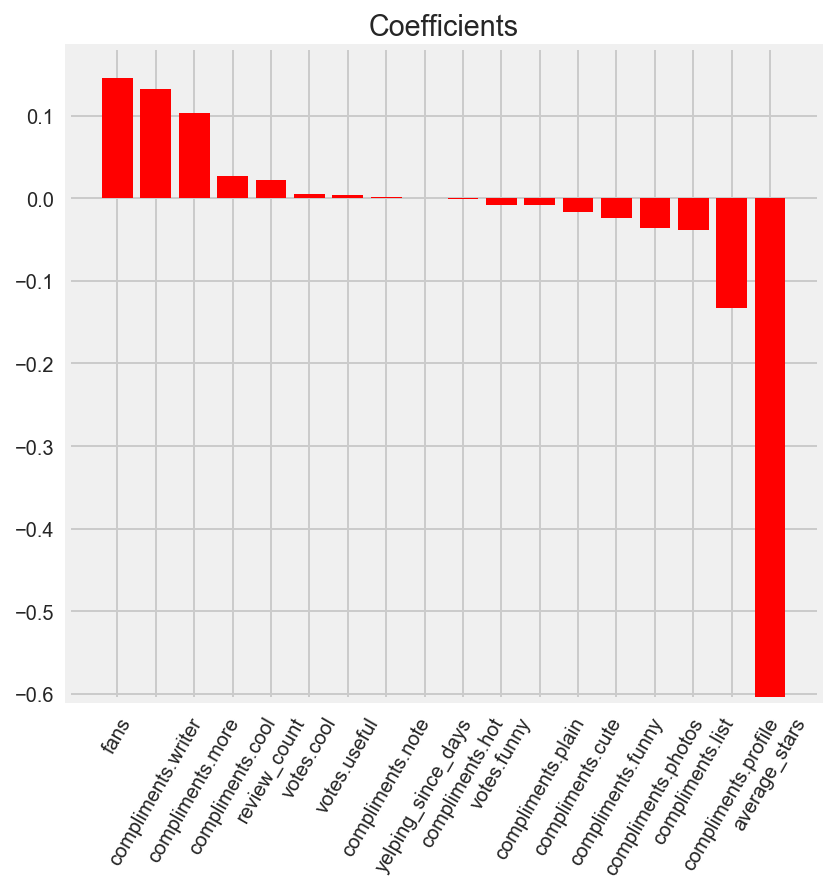

In [113]:
top_predictors = sorted(zip(lr.coef_[0], predictor_cols), reverse=True)

print top_predictors

values = [value for value, predictors in top_predictors]
predictors = [predictors for value, predictors in top_predictors]

# Plot the feature importances of the forest
plt.figure(figsize=(6,6))
plt.title("Coefficients")
plt.bar(range(len(predictors)), values,color="r", align="center");
plt.xticks(range(len(predictors)), predictors, rotation=60);


**NOTE** So average_stars is the main coefficient for elite users if you remove all 'count' columns. 

### Think of a way to visually represent your results in a compelling way. Give a brief write-up of your findings.

In [114]:
from IPython.display import Image

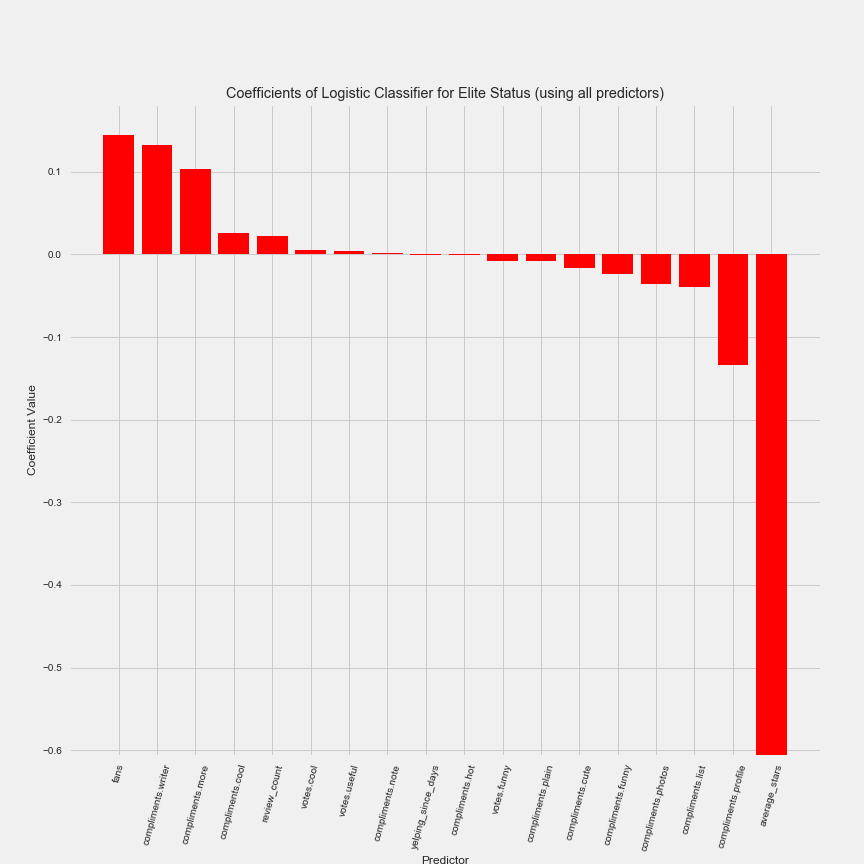

In [115]:
Image('./Coefficients of Logistic Classifier for Elite Status (using all predictors).png')

**CONCLUSION** Most significant predictors for an elite user? Number of fans, number of compliments (Good Writer, and Write More, Like your Profile) and average rating. The negative coef for average_stars indicates that the predictor is inverseley associated with the probability of a user being classified elite. So as a user's rating average increases the likelihood that they are elite decreases significantly. 

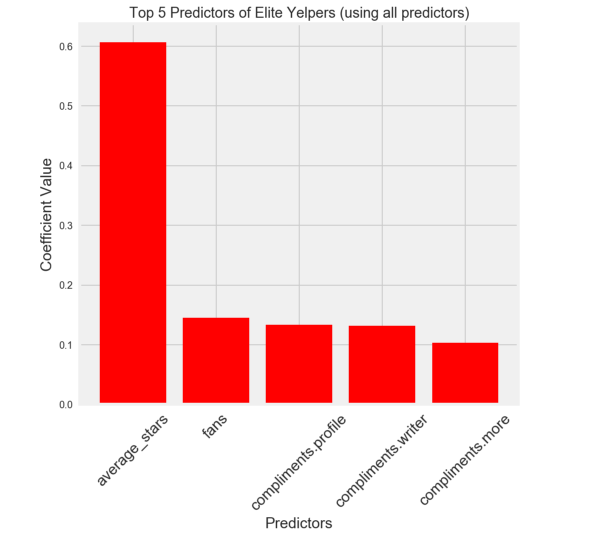

In [116]:
Image(filename='./top_5_predictors.png')

The 5 most significant predictors, with the absolute value of their beta coefficients, are shown above. 

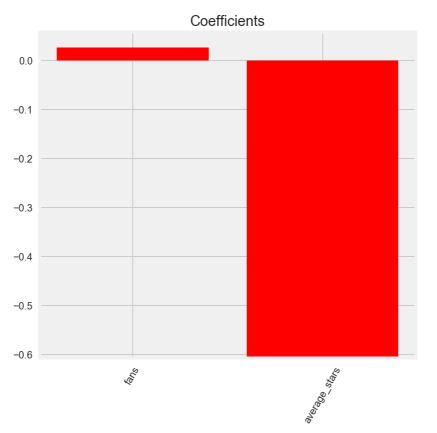

In [117]:
Image('./top_5_predictors_2_cols.png')

However if you only use the average_stars and fans columns to create the model, then average_stars far outweighs fans in terms of predicting whether a yelp user is elite or not. 

**BELOW HERE IS NOT BEING USED**
===========
=======================

In [118]:
users = pd.read_csv('/Users/Naekid/Desktop/DSI-SF-5-fork/DSI-SF-5/datasets/yelp_arizona_data/users_small_parsed.csv')

In [119]:
non_elite_user_indices = set(sorted(users[users['elite']=='[]'].index.values))

all_user_indices = set(sorted(users.index.values))

elite_user_indices = list(all_user_indices - non_elite_user_indices)
non_elite_user_indices = list(non_elite_user_indices)


elite_users = users.iloc[elite_user_indices, :]
non_elite_users = users.iloc[non_elite_user_indices, :]

del non_elite_user_indices, elite_user_indices, all_user_indices # don't want them in the namespace 

**Clean the non-elite user dataframe**

In [120]:
print non_elite_users.shape
print (non_elite_users.isnull().sum()/non_elite_users.shape[0]).map(lambda x: round(x,2)).sort_values(ascending=False)

(127583, 21)
compliments.list       0.99
compliments.profile    0.97
compliments.cute       0.96
compliments.photos     0.94
compliments.more       0.91
compliments.funny      0.87
compliments.hot        0.87
compliments.writer     0.86
compliments.note       0.81
compliments.cool       0.80
compliments.plain      0.76
votes.useful           0.00
review_count           0.00
fans                   0.00
average_stars          0.00
elite                  0.00
name                   0.00
user_id                0.00
votes.cool             0.00
votes.funny            0.00
yelping_since          0.00
dtype: float64


We have a TON of missing values in this dataframe... Not sure what to do about that. It might be the case that if a user didn't get any compliments, then they just got an NA. So let's check for that

In [121]:
sorted(non_elite_users['compliments.cool'].unique())

[1.0,
 2.0,
 3.0,
 4.0,
 nan,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 105.0,
 106.0,
 108.0,
 109.0,
 111.0,
 112.0,
 114.0,
 115.0,
 116.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 125.0,
 127.0,
 128.0,
 129.0,
 130.0,
 132.0,
 133.0,
 134.0,
 136.0,
 140.0,
 141.0,
 143.0,
 145.0,
 147.0,
 150.0,
 151.0,
 152.0,
 155.0,
 156.0,
 157.0,
 159.0,
 165.0,
 166.0,
 173.0,
 179.0,
 188.0,
 1

And that appears to be the case. So we can replace all NA with 0. That will help. 

In [122]:
np.isnan(non_elite_users['compliments.list'].iloc[0])

True

In [123]:
def check_for_nan(x):
    try:
        if(np.isnan(x)):
            return int(0)
        else:
            return x
    except:
        return x

non_elite_users = non_elite_users.applymap(check_for_nan)

In [124]:
non_elite_users.isnull().sum()

yelping_since          0
compliments.plain      0
review_count           0
compliments.cute       0
compliments.writer     0
fans                   0
compliments.note       0
compliments.hot        0
compliments.cool       0
compliments.profile    0
average_stars          0
compliments.more       0
elite                  0
name                   0
user_id                0
votes.cool             0
compliments.list       0
votes.funny            0
compliments.photos     0
compliments.funny      0
votes.useful           0
dtype: int64

In [125]:
np.mean(non_elite_users['average_stars'])

3.7643695476670085

**Clean the elite users dataframe**

In [126]:
print elite_users.shape
print (elite_users.isnull().sum()/elite_users.shape[0]).map(lambda x: round(x,2)).sort_values(ascending=False)

(16623, 21)
compliments.list       0.64
compliments.cute       0.49
compliments.profile    0.46
compliments.photos     0.33
compliments.more       0.21
compliments.funny      0.16
compliments.writer     0.08
compliments.hot        0.08
compliments.note       0.07
compliments.plain      0.04
compliments.cool       0.04
votes.useful           0.00
review_count           0.00
fans                   0.00
average_stars          0.00
elite                  0.00
name                   0.00
user_id                0.00
votes.cool             0.00
votes.funny            0.00
yelping_since          0.00
dtype: float64


In [127]:
elite_users = elite_users.applymap(check_for_nan)

In [128]:
np.mean(elite_users['average_stars'])

3.7979023040365751

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

**NOTE** I was thinking about whether to do this or #5, and I think I need the practice with ROC and error metrics like precision/recall, so I'm going to do #5. 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

In [204]:
business_cleaned.head()

,business_id,name,review_count,stars,Airports,Breakfast & Brunch,Bubble Tea,Burgers,Bars,Bakeries,Breweries,Cafes,Candy Stores,Comedy Clubs,Courthouses,Dance Clubs,Fast Food,Museums,Tattoo,Vape Shops,Yoga,attributes.Accepts Credit Cards_False,attributes.Accepts Credit Cards_True,attributes.Accepts Insurance_False,attributes.Ages Allowed_18plus,...,hours.Wednesday.open_12:00,hours.Wednesday.open_12:30,hours.Wednesday.open_13:00,hours.Wednesday.open_14:00,hours.Wednesday.open_14:30,hours.Wednesday.open_15:00,hours.Wednesday.open_15:30,hours.Wednesday.open_16:00,hours.Wednesday.open_16:30,hours.Wednesday.open_17:00,hours.Wednesday.open_17:30,hours.Wednesday.open_18:00,hours.Wednesday.open_18:30,hours.Wednesday.open_19:00,hours.Wednesday.open_19:30,hours.Wednesday.open_20:00,hours.Wednesday.open_20:30,hours.Wednesday.open_21:00,hours.Wednesday.open_21:30,hours.Wednesday.open_22:00,hours.Wednesday.open_22:30,hours.Wednesday.open_23:00,open_False,open_True,city
0,EmzaQR5hQlF0WIl24NxAZA,Sky Lounge,25,2.5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,SiwN7f0N4bs4ZtPc4yPgiA,Palazzo,19,3.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,e5kc0CQ4R-PCCDgb274gSg,Canyon Cafe,238,3.5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,neGAQFkBNI8-rpPBLBzNkw,Taco Bell,10,4.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,45puCRQ6Vh_IIAy7kkfFDQ,Majerle's Sports Grill,205,3.5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [205]:
business_cleaned.iloc[:, 16].value_counts()

0    3045
1    1087
Name: Fast Food, dtype: int64

In [206]:
print 'Baseline fast food precision for 1s:', business_cleaned.iloc[:, 16].value_counts()[1]/business_cleaned.iloc[:, 16].count()

Baseline fast food precision for 1s: 0.263068731849


In [207]:
business_cleaned.iloc[:, 10].value_counts()

0    4099
1      33
Name: Breweries, dtype: int64

In [208]:
# print 'MAX brewery accuracy:', business_cleaned.iloc[:, 10].value_counts()[1]/business_cleaned.iloc[:, 10].value_counts().sum()
print 'Baseline precision for all 1s:',business_cleaned.iloc[:, 10].value_counts()[1]/business_cleaned.iloc[:, 10].value_counts().sum()
print 'Baseline precision for all 0s:',business_cleaned.iloc[:, 10].value_counts()[0]/business_cleaned.iloc[:, 10].count()

Baseline precision for all 1s: 0.00798644724105
Baseline precision for all 0s: 0.992013552759


In other words, if we classified all businesses as being breweries, we would get 33 TP, and 4099 FP, and Precision = TP / TP + FP.

** Random Forest on BREWERIES**

In [134]:
predictor_cols = business_cleaned.columns.tolist()[21:-4]
brewery_target_col = business_cleaned.columns.tolist()[10]
fast_food_target_col = business_cleaned.columns.tolist()[16]

In [135]:
X = business_cleaned[predictor_cols].values
y = business_cleaned[brewery_target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [136]:
rfc = RandomForestClassifier()

params = {
    'n_estimators': [10, 100], # number of trees in the forest
    'min_samples_leaf':[15, 30, 50],
    'max_leaf_nodes':[50, 100]
}


gs = GridSearchCV(rfc, param_grid=params, verbose=1, scoring='precision')

gs.fit(X, y)

gs.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   15.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [10, 100], 'max_leaf_nodes': [50, 100], 'min_samples_leaf': [15, 30, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='precision', verbose=1)

{'max_leaf_nodes': 50, 'min_samples_leaf': 15, 'n_estimators': 10}

In [137]:
gs.best_score_

0.0

That's terrible. We'll make a model with our best parameters.

In [138]:
rfc = RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=15, n_estimators=10)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=50,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [139]:
sum(y_pred)

0

In [140]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print cm
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print TN, FN, TP, FP
print 'Precision (TP, FP): ', TP, FP, 'Prec = ', (TP)/(TP + FP)
print 'recall (TP, FN): ', TP, FN, 'Recall = ', (TP)/(TP + FN)

[[1230    0]
 [  10    0]]
1230 10 0 0
Precision (TP, FP):  0 0 Prec =  nan
recall (TP, FN):  0 10 Recall =  0.0


/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in long_scalars


The confusion matrix tells us that we got 1230 True Negatives, 0 False Negatives, 0 True Positives, and 0 False Positives. That makes sense because our model just classified everything as 0, so we didn't classify any positives, true or false. 

In [141]:
from sklearn.metrics import classification_report
predictions = gs.predict(X_test)
print classification_report(y_test, predictions, digits=4)

             precision    recall  f1-score   support

          0     0.9919    1.0000    0.9960      1230
          1     0.0000    0.0000    0.0000        10

avg / total     0.9839    0.9919    0.9879      1240



/Users/Naekid/anaconda3/envs/dsi/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Our baseline was 0.00798 for classifying as a 1, and we got 0.0000 with our model, so our model is doing worse than baseline. 

(0.0, 1.0)

(0.0, 1.05)

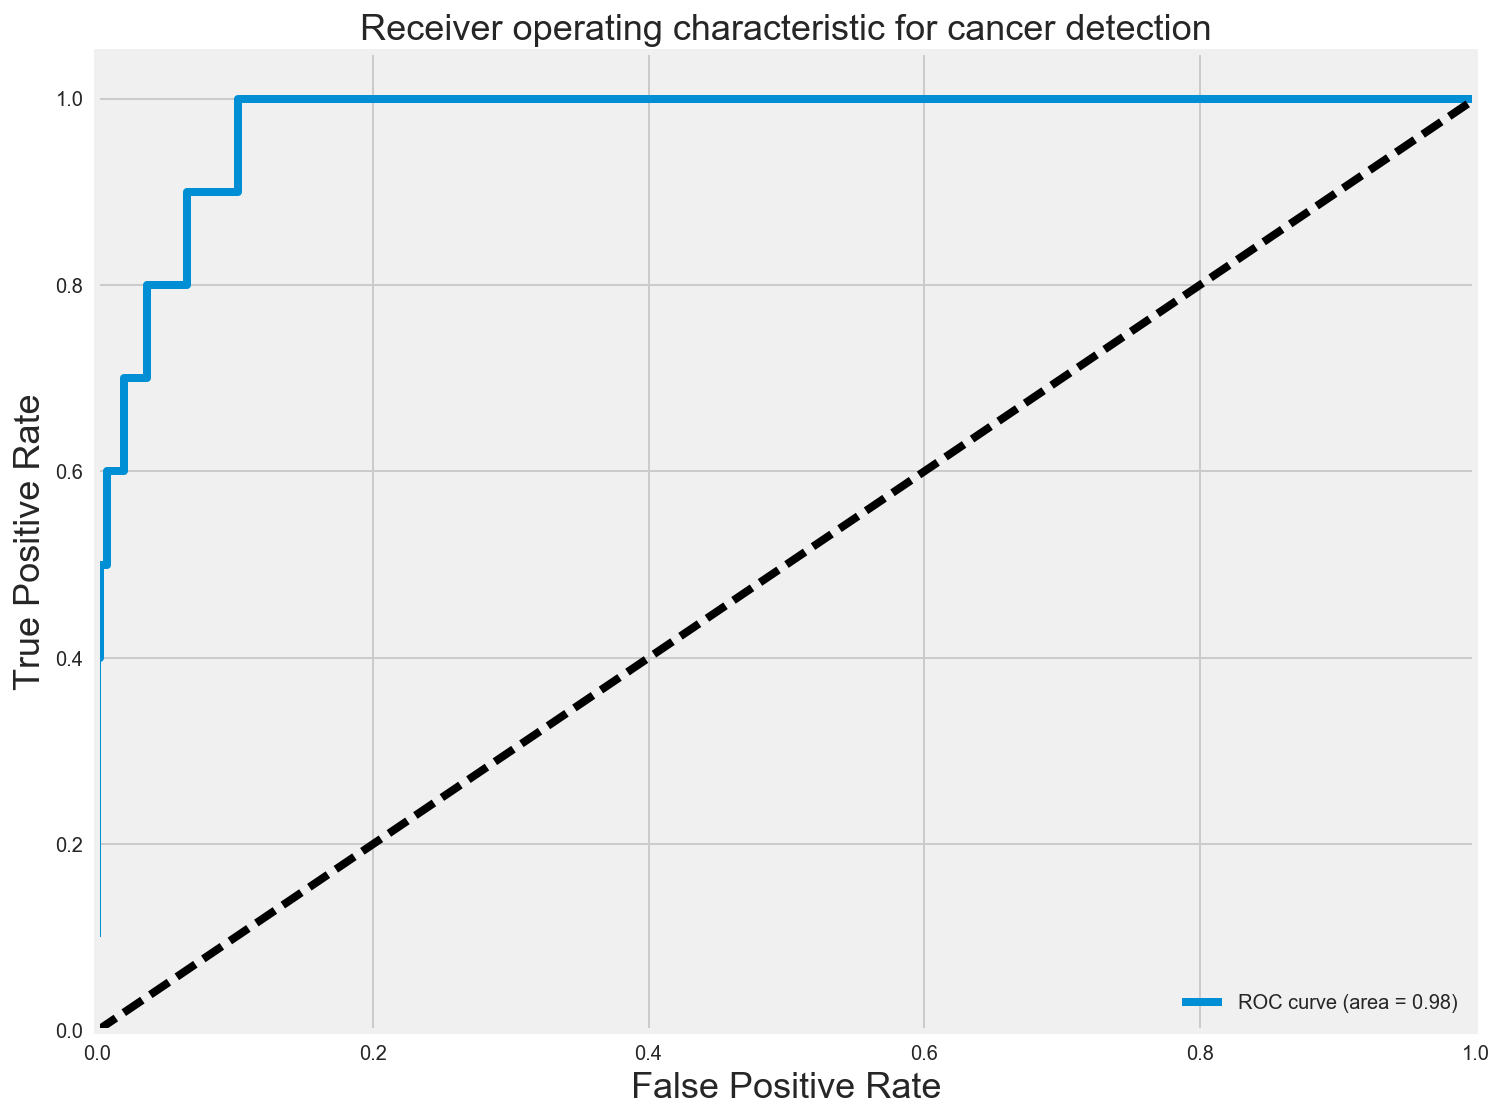

In [142]:
from sklearn.metrics import roc_curve, auc

y_prob = gs.best_estimator_.predict_proba(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_prob[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

All I remember from ROC is that the closer the curve hugs the top left hand corner, the better the model performs. Each point on the ROC curve represents a TP/FP value which corresponds to a decision threshold (probability threshold for selecting class 1). The bottom left starts with a threshold of 100% for assigning class 1, and then moves down to 0% in the top right. As we decrease the threshold, we start to get more true positives (and normally, false positives as well, just more positives in general), as the threshold for positive classification falls below the probabilities returned from the  logistic regression function

<br><br>The area under the ROC curve (AUC) is a measure of how well a the model classifies the samples. 

In this case, it's very low, which is what we expect from our error metrics. 

In [209]:
from sklearn.metrics import precision_recall_curve


# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

IndexError: too many indices for array

**Random Forest FAST FOOD**

In [210]:
X = business_cleaned[predictor_cols].values
y = business_cleaned[fast_food_target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

KeyError: "['average_stars' 'compliments.cool' 'compliments.cute' 'compliments.funny'\n 'compliments.hot' 'compliments.list' 'compliments.more' 'compliments.note'\n 'compliments.photos' 'compliments.plain' 'compliments.profile'\n 'compliments.writer' 'fans' 'votes.cool' 'votes.funny' 'votes.useful'\n 'yelping_since_days'] not in index"

In [ ]:
rfc = RandomForestClassifier()

params = {
    'n_estimators': [10, 100], # number of trees in the forest
    'min_samples_leaf':[15, 30, 50],
    'max_leaf_nodes':[50, 100]
}


gs = GridSearchCV(rfc, param_grid=params, verbose=1, scoring='precision')

gs.fit(X_train, y_train)

print gs.best_params_
print 'best score: ',gs.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


our Baseline fast food precision for 1s: 0.263, so this is a pretty good precision. 

In [ ]:
y_pred = gs.best_estimator_.predict(X_test)

In [147]:
cm = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print cm
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
print TN, FN, TP, FP
print 'Precision (TP, FP): ', TP, FP, 'Prec = ', (TP)/(TP + FP)
print 'recall (TP, FN): ', TP, FN, 'Recall = ', (TP)/(TP + FN)

[[877  54]
 [ 71 238]]
877 71 238 54
Precision (TP, FP):  238 54 Prec =  0.815068493151
recall (TP, FN):  238 71 Recall =  0.770226537217


In [148]:
from sklearn.metrics import classification_report
predictions = gs.predict(X_test)
print classification_report(y_test, predictions, digits=4)

             precision    recall  f1-score   support

          0     0.9251    0.9420    0.9335       931
          1     0.8151    0.7702    0.7920       309

avg / total     0.8977    0.8992    0.8982      1240



So we got a precision of 0.83, much better than the baseline of 0.263!! Cool. 

1. Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?

(0.0, 1.0)

(0.0, 1.05)

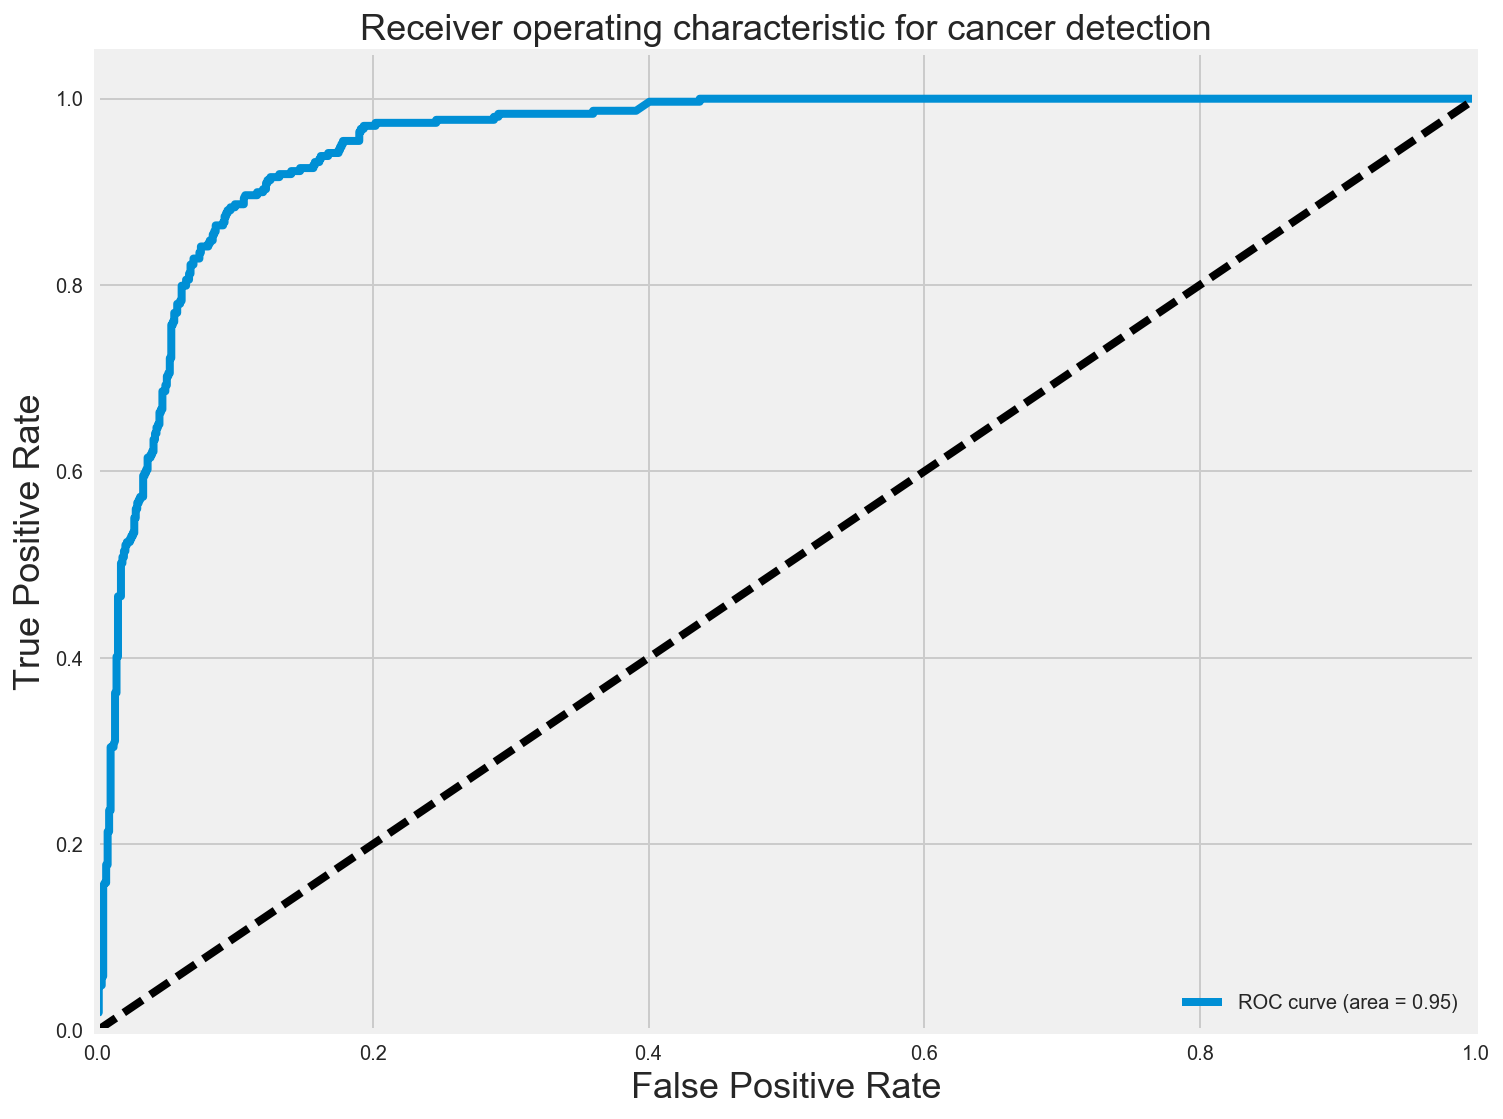

In [149]:
from sklearn.metrics import roc_curve, auc

y_prob = gs.best_estimator_.predict_proba(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, y_prob[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for cancer detection', fontsize=18)
plt.legend(loc="lower right")
plt.show()

This has a high AUC, so the model is doing good, as we expected. 

2. Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?

In [150]:
from sklearn.metrics import precision_recall_curve


# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(2):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")

# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

IndexError: too many indices for array

3. Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?

## OOP, Stochastic Gradient Descent, and Linear Algebra

---

In this part of the project, you will implement machine learning algorithms we have covered in class from scratch. 

--- 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 6. Implement the `LinearRegrssion` class using Stochastic Gradient Descent to include the following: 

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklearn]


Protip: Compare if your implemenation works by applying it on the Diabetes Dataset and seeing it how it compares to opensource implemenations in `sklearn` and `statsmodels`. 

http://statsmodels.sourceforge.net/devel/examples/#regression

http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### 7. Extend the Binary `LogisticRegression` model to implement Multi-class classification that fits the model using Stochastic Gradient Descent. Include the following : 

- Use the program we coded in class that implemented Logistic regression for Binary classification and extend it to implement Multi-class classification 
  - [Binary Logistic regression program](https://github.com/ga-students/DSI-SF-5/blob/master/curriculum/week-04/logistic_regression/Logistic_regression.py)

- An option to regularize the model with Ridge Regression. The method should automatically calculate the best `alpha` for the user. The closed form solution for Ridge Regression may be helpful [Hint: Think of the `n_alphas` parameter in sklear

Check if the results of your `LogisticRegression` implementation matches with the Sklearn implementation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">
### 8. Singular Value Decomposition 

- Read articles on image compression with SVD and use `numpy` apply it to images from the MNIST Datasets. To get the MNIST Datset, use the following comands. Note that the `mnist` data has shape `(70000, 784)`. You will need to convert it to 28x28 images [Hint: `np.reshape`]. 
       
       from sklearn.datasets import fetch_mldata
       mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

    https://inst.eecs.berkeley.edu/~ee127a/book/login/l_svd_apps_image.html

    http://www.frankcleary.com/svdimage/
    
    
- Apply Logistic Regression to classify MNIST Images. This may require having the images be `784` dimensions rather than `28x28`. Compare results of the classifier on a test set when you apply it on the raw dataset vs. the compressed version of dataset from SVD. 

**NOTE** I had already done something similar earlier in the month. 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

from PIL import Image

from sklearn.datasets import fetch_mldata

custom_data_home = '/Users/Naekid/Desktop/DSI-SF-5-fork/DSI-SF-5/curriculum/week-02/Linear_Algebra/'

mnist = fetch_mldata('MNIST original', data_home=custom_data_home)

import pprint
pprint.pprint(mnist)

mnist_data = mnist.data.view()
mnist_new = np.reshape(mnist_data.data, (70000,28,28))

mnist_new[0].shape

imggray = mnist_new[0]
plt.figure(figsize=(9, 6))
plt.imshow(imggray)

imgmat = np.array(list(imggray), float)
imgmat = np.matrix(imgmat)
plt.figure(figsize=(9,6))
plt.imshow(imgmat, cmap='gray');

U, sigma, V = np.linalg.svd(imgmat)

imgmat.shape

reconstimg = np.matrix(U[:, :1]) * np.diag(sigma[:1]) * np.matrix(V[:1, :])
plt.imshow(reconstimg, cmap='gray');

for i in xrange(5, imgmat.shape[0], 4):
    reconstimg = np.matrix(U[:, :i]) * np.diag(sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

## Optional: Interview Practice

## Coding Questions 
- Implement Binary Search in Python and write down the algorithmic complexity of the Binary Search Algorithm.


- Implement Merge Sort in Python [Hint: First implement the `merge` function that combines two sorted arrays into one sorted array linear time]. What is the time complexity of `mergesort` ?


- Find the closest pair from two sorted arrays. Given two sorted arrays and a number x, find the pair whose sum is closest to x and the pair has an element from each array. We are given two arrays ar1[0…m-1] and ar2[0..n-1] and a number x, we need to find the pair ar1[i] + ar2[j] such that absolute value of (ar1[i] + ar2[j] – x) is minimum. What is the time complexity of this algorithm?

In [ ]:
#Recursive function to implement merge sort

def merge_sort(input_list):
    
    # Basecase
    if len(input_list) <= 1:
        return input_list
    
    middle_index = len(input_list)/2
    
    l = merge_sort(input_list[:middle_index])
    r = merge_sort(input_list[middle_index:])
    
    return merge(l, r)


def merge(left,right):xw

    # Basecase
    if not left:
        return right
    if not right:
        return left
    
    first_left = left[0]
    first_right = right[0]
    
    # if there is at least 1 element in both lists 
    if first_left < first_right:
        return [first_left] + merge(left[1:], right)
    
    return [first_right] + merge(left, right[1:])
        


## Probability  and Statistics Questions 

- In any 15-minute interval, there is a 20% probability that you will see at least one shooting star. What is the probability that you see at least one shooting star in the period of an hour?


- A certain couple tells you that they have two children, at least one of which is a girl. What is the probability that they have two girls?


## Interview Questions Related to Material

- Explain what is bias-variance tradeoff to a non-technical person. Why is it a useful framework? How do you detect bias in your models? How about you variance? 

- Explain why cross-validation is important. 

- What is regularization? What are the advantages/disadvantages of different types of regularization schemes? 

- What are the loss functions associated with linear regression, logistic regression, and KNN? 

- Can you give examples of feature engineering on datasets you have worked with? 